<center>
<h3> </h3>
<h1>DATA 5600 - Introduction to Linear Regression and Machine Learning</h1>
<h2>Group Data Analysis 2 - Multiple Linear Regression</h2>
<h3> Dallin Moore & Vincent Rohrer <h3>
</center>

## Introduction

The data that we are observing is the demand for bikes through a bike rental service in Seoul South Korea. Our goal is to develop a model to accurately predict this demand based on the variables provided in the data, including the effect that the day of the week, hour, or weather, has on demand. Assuming our model is accurate, we will then move forward with practical applications for predicting demand, including determining maintenance times at low demand periods and implementing dynamic pricing strategies

*Citation: Seoul Bike Sharing Demand [Dataset]. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.*


### Load in Libraries

In [5]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from ucimlrepo import fetch_ucirepo
import textwrap as tw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.graphics.factorplots import interaction_plot
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from itertools import combinations

# suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Examine the Dataset

In [7]:
# fetch dataset
full_bike_df = fetch_ucirepo(id=560)
# metadata
print("Summary:",tw.fill(full_bike_df.metadata['additional_info']['summary'], width=80))
print()
print(full_bike_df.metadata['additional_info']['variable_info'])

Summary: Currently Rental bikes are introduced in many urban cities for the enhancement
of mobility comfort. It is important to make the rental bike available and
accessible to the public at the right time as it lessens the waiting time.
Eventually, providing the city with a stable supply of rental bikes becomes a
major concern. The crucial part is the prediction of bike count required at each
hour for the stable supply of rental bikes.   The dataset contains weather
information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar
radiation, Snowfall, Rainfall), the number of bikes rented per hour and date
information.

Date : year-month-day
Rented Bike count - Count of bikes rented at each hour
Hour - Hour of he day
Temperature-Temperature in Celsius
Humidity - %
Windspeed - m/s
Visibility - 10m
Dew point temperature - Celsius 
Solar radiation - MJ/m2
Rainfall - mm
Snowfall - cm
Seasons - Winter, Spring, Summer, Autumn
Holiday - Holiday/No holiday
Functional Day - NoFunc(Non

**To prepare the dataset:**

1. Shrink the DataFrame down to 5,000 observations.

2. Given that the `Functioning Day` would not be given to make predictions on, it will be dropped from the dataset. Observations when the service was not functioning will also be removed. (Note: `Demand` is also `0` if `Functioning Day` is `No`.)

3. `Season` is dropped as there is expected to be a big multicollinearity with all of the weather variables.


In [8]:
# Create a DataFrame from the features/targets and make it smaller
bike_df = pd.DataFrame(full_bike_df.data.features)
bike_df[str(full_bike_df.data.targets.columns[0])] = full_bike_df.data.targets
bike_df = bike_df[bike_df['Functioning Day'] == 'Yes']
bike_df = bike_df.drop('Functioning Day', axis=1)
bike_df = bike_df.drop('Seasons', axis=1)
bike_df = bike_df.sample(n=5000, random_state=1)  # random_state for reproducibility
bike_df.columns = bike_df.columns.str.replace(' ', '_') # replace spaces with underscores
bike_df.head()

Date  Rented_Bike_Count  Hour  Temperature  Humidity  Wind_speed  \
2634  20/03/2018               1111    18          4.1        43         3.5   
4627   11/6/2018                873    19         19.4        85         1.2   
8392  15/11/2018               1123    16         15.4        34         1.4   
1768   12/2/2018                239    16         -2.4        33         4.5   
4138  22/05/2018               1119    10         20.7        55         1.8   

      Visibility  Dew_point_temperature  Solar_Radiation  Rainfall  Snowfall  \
2634        2000                   -7.3             0.21       0.0       0.0   
4627        1651                   16.8             0.08       0.5       0.0   
8392        1016                   -0.4             0.68       0.0       0.0   
1768        1815                  -16.5             1.55       0.0       0.0   
4138        1698                   11.3             1.43       0.0       0.0   

         Holiday  
2634  No Holiday  
4627  No Holiday  
8392  No Holiday  
1768  No Holiday  
4138     Holiday

### Exploratory Data Analysis

#### Continuous Data

In [9]:
bike_df.drop('Hour', axis=1).describe()

Rented_Bike_Count  Temperature     Humidity   Wind_speed   Visibility  \
count        5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean          734.936000    12.870440    58.185400     1.728060  1427.501600   
std           646.021839    12.107273    20.389894     1.023752   611.465364   
min             2.000000   -17.800000     0.000000     0.000000    27.000000   
25%           212.000000     3.100000    42.750000     1.000000   924.750000   
50%           555.000000    13.700000    57.000000     1.500000  1673.000000   
75%          1095.000000    22.700000    74.000000     2.300000  2000.000000   
max          3384.000000    39.400000    98.000000     7.400000  2000.000000   

       Dew_point_temperature  Solar_Radiation     Rainfall     Snowfall  
count            5000.000000      5000.000000  5000.000000  5000.000000  
mean                4.065960         0.568016     0.158780     0.078080  
std                13.268638         0.860439     1.166411     0.466003  
min               -30.500000         0.000000     0.000000     0.000000  
25%                -5.000000         0.000000     0.000000     0.000000  
50%                 4.900000         0.010000     0.000000     0.000000  
75%                15.300000         0.930000     0.000000     0.000000  
max                26.600000         3.520000    35.000000     8.800000

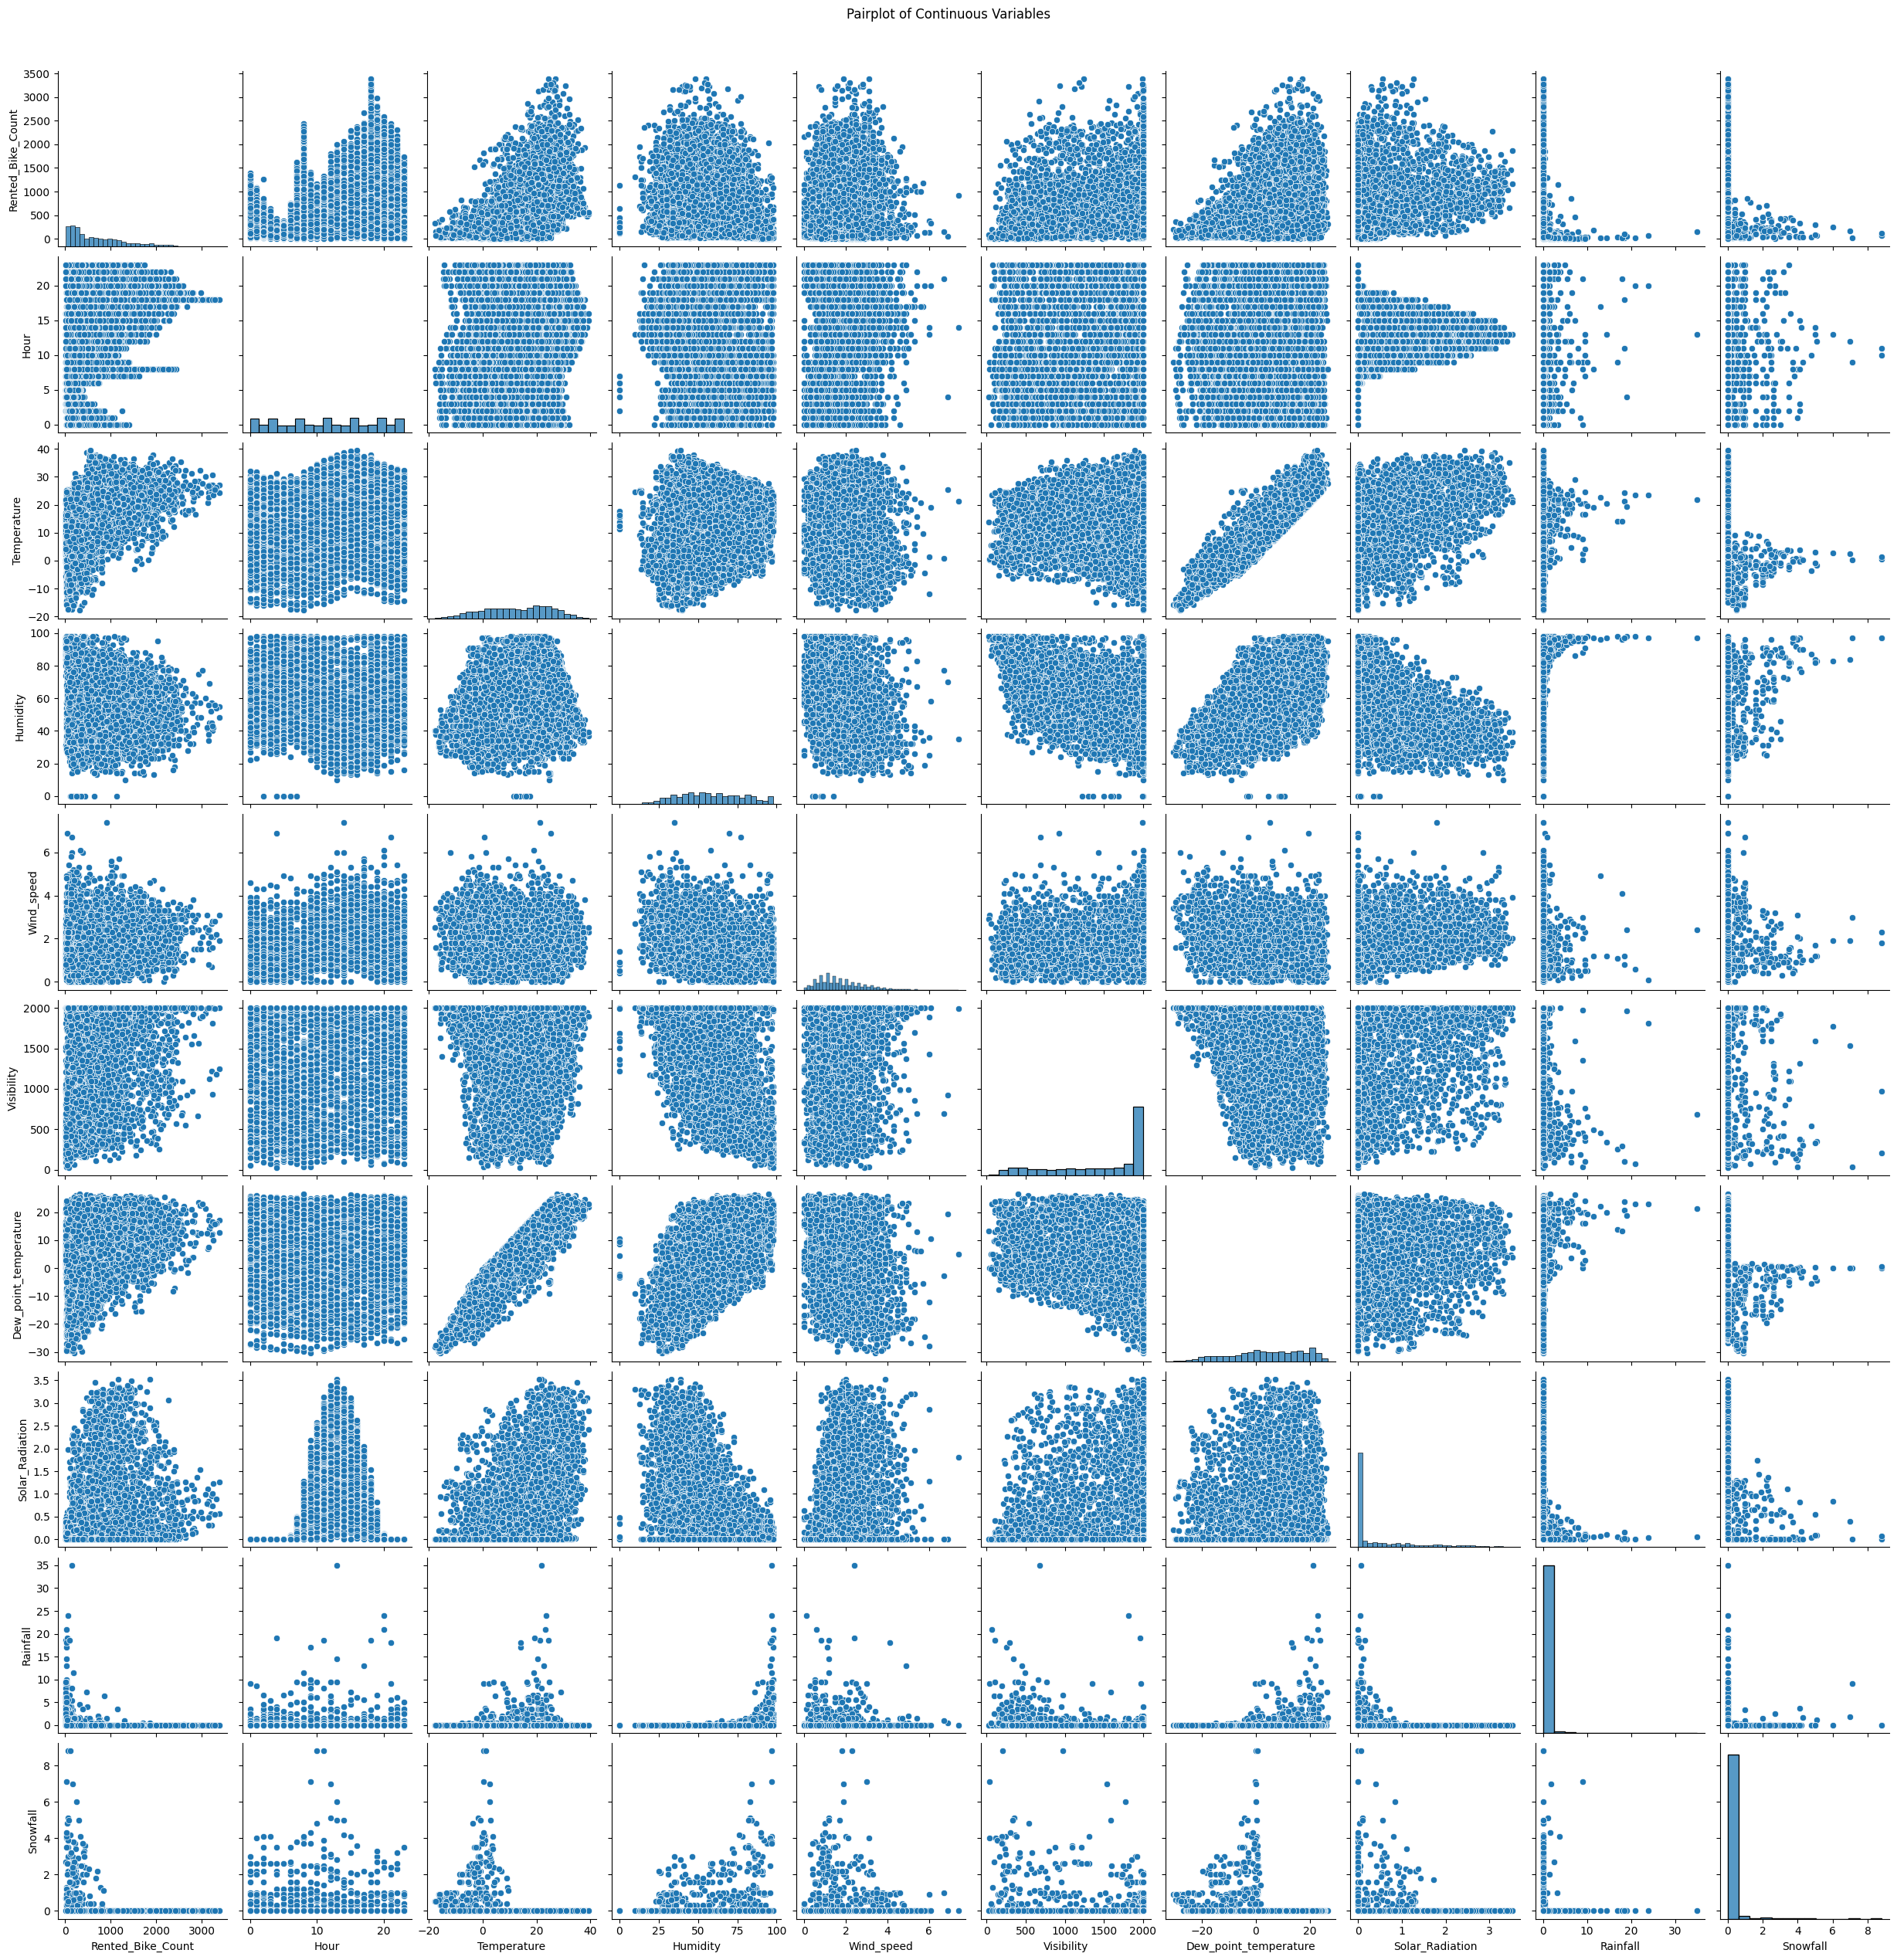

In [10]:
sns.pairplot(bike_df)
plt.suptitle('Pairplot of Continuous Variables', y=1.02)
plt.show()

Seeing the high linear association between `temperature` and `dew point temperature` is an immediate red flag. One of these variables will likely need to be removed to mitigate any multicollinearity; our selection methods will take care of this.

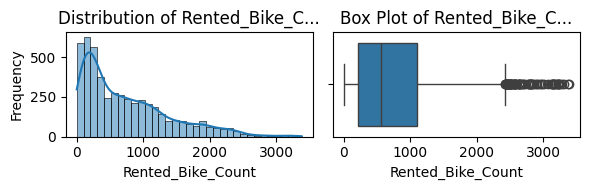

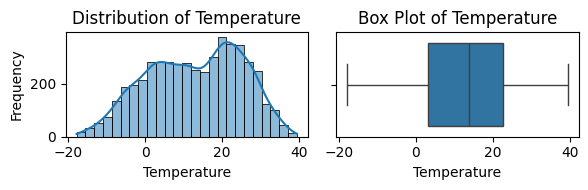

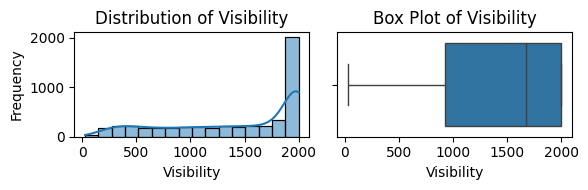

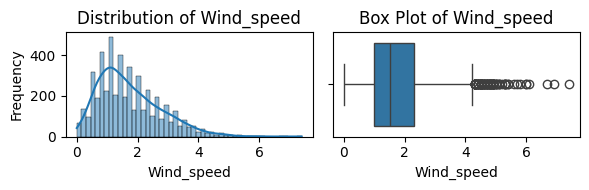

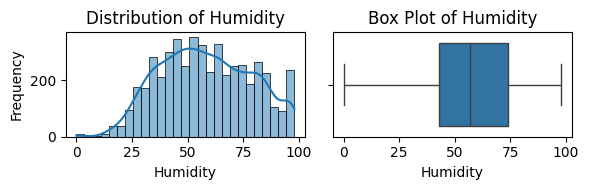

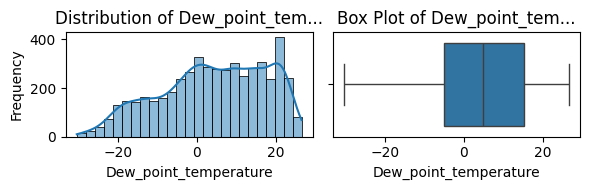

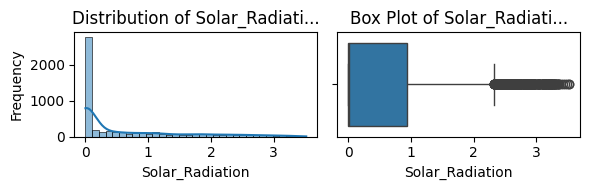

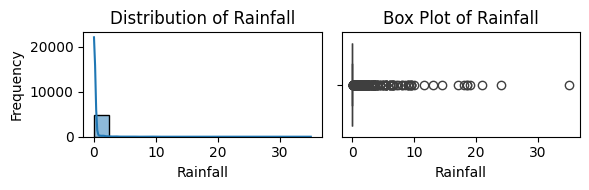

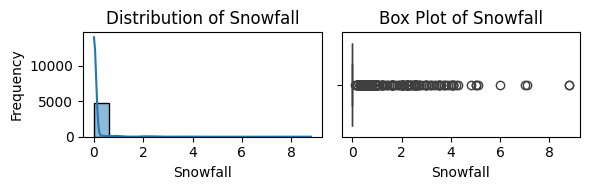

In [11]:
def show_distribution(column):
    column_name = column if len(column)< 13 else column[:13]+'...'
    fig, axes = plt.subplots(1, 2, figsize=(6, 2))

    # Plot the histogram with density curve on the first axis
    sns.histplot(bike_df[column], kde=True, ax=axes[0])  # Use kde=True for a density curve
    axes[0].set_title('Distribution of ' + column_name)
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frequency')

    # Plot the box plot on the second axis
    sns.boxplot(x=bike_df[column], ax=axes[1])
    axes[1].set_title('Box Plot of ' + column_name)
    axes[1].set_xlabel(column)

    plt.tight_layout()  # Adjust spacing between plots
    plt.show()

# Example usage
show_distribution('Rented_Bike_Count')
show_distribution('Temperature')
show_distribution('Visibility')
show_distribution('Wind_speed')
show_distribution('Humidity')
show_distribution('Dew_point_temperature')
show_distribution('Solar_Radiation')
show_distribution('Rainfall')
show_distribution('Snowfall')


Variables to be concerned about from the start are `solar radiation`, `rainfall`, and `snowfall`, which all have a very small inter quartile range at very low values, indicating that these values are mostly very low and the distribution is highly right skewed. This means that there are also many outliers for each of these variables.

#### Categorical Data

The following variables will be transformed into continuous variables:

* Date &rarr; Day of the week
* Hour (continuous) &rarr; Hour (categorical)
* Rain/Snow (continuous) &rarr; Precipitation (binary)

\* Snow and Rain amounts are kept in dataset as well as the new Precipitation column to account for the large amount of data that has no percipitation.

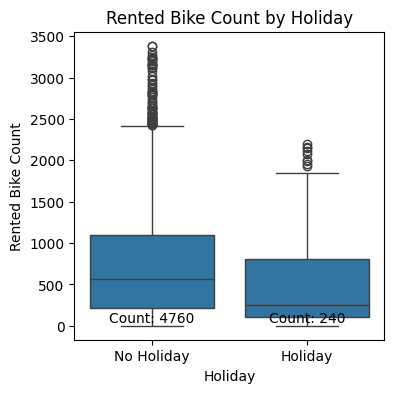

In [12]:
plt.figure(figsize=(4, 4))

# Create the boxplot
sns.boxplot(x='Holiday',
            y='Rented_Bike_Count',
            data=bike_df)

# Calculate value counts
counts = bike_df['Holiday'].value_counts()

# Add counts to the plot
for i, count in enumerate(counts):
    plt.text(i, 1, f'Count: {count}', ha='center', va='bottom')  # Adjust the y position as needed

plt.title('Rented Bike Count by Holiday')
plt.xlabel('Holiday')
plt.ylabel('Rented Bike Count')
plt.show()


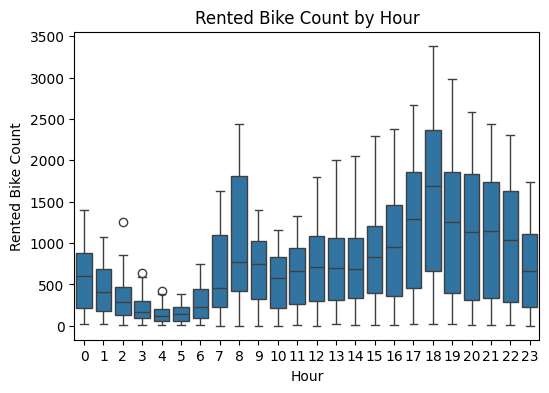

In [13]:
plt.figure(figsize = (6, 4))
sns.boxplot(x = 'Hour',
            y = 'Rented_Bike_Count',
            data = bike_df)
plt.title('Rented Bike Count by Hour')
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.show()

There are clear trends with the box plots as we can see low rented bike count trends during the early morning, and higher demand at high travel times that correspond with the average working day in South Korea (9:00 AM - 6:00 PM).

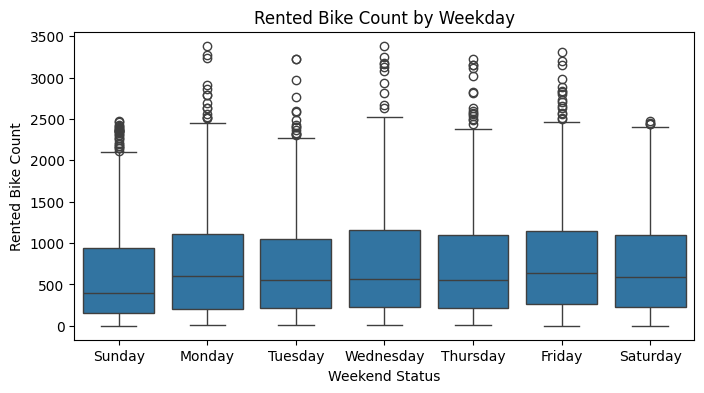

In [14]:
bike_df['Date'] = pd.to_datetime(bike_df['Date'], dayfirst=True)
bike_df['Day'] = bike_df['Date'].dt.day_name()

plt.figure(figsize = (8, 4))
sns.boxplot(x = 'Day',
            y = 'Rented_Bike_Count',
            data = bike_df,
            order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title('Rented Bike Count by Weekday')
plt.xlabel('Weekend Status')
plt.ylabel('Rented Bike Count')
plt.show()

Though it is not as extreme as the time of day, there are observable trends in the rented bike count for each day of the week. Sunday has the lowest median while friday is the highest. There is little fluctuation from day to day, but enough to see that weekends appear to experience less demand than weekdays.

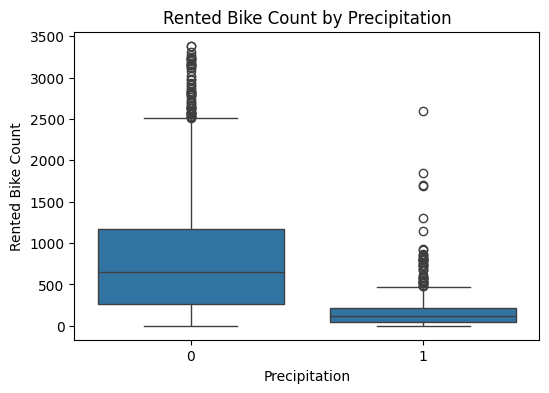

In [15]:
bike_df['Precipitation'] = ((bike_df['Rainfall'] > 0) | (bike_df['Snowfall'] > 0)).astype(int)

plt.figure(figsize = (6, 4))
sns.boxplot(x = 'Precipitation',
            y = 'Rented_Bike_Count',
            data = bike_df)
plt.title('Rented Bike Count by Precipitation')
plt.xlabel('Precipitation')
plt.ylabel('Rented Bike Count')
plt.show()

Rain appears to have a significant effect on the rented bike count, as days with any precipitation have a dramatic decrease in thier total rented bike count.

## Variable Selection

#### Dummy Code Categorical Variables

Create a new DataFrame that contains all of the variables, including the dummy coded variables, for the analysis.

In [16]:
# dummy code categorical variables
bike_df_dummy = bike_df.copy()
bike_df_dummy = pd.get_dummies(bike_df, columns=['Day', 'Hour'], drop_first=False, dtype=int)
bike_df_dummy.drop(columns = ['Day_Sunday'], inplace = True) # Use sunday as the baseline since it has the lowest average rented bike count
bike_df_dummy.drop(columns = ['Hour_0'], inplace = True)
bike_df_dummy.drop(columns = ['Date'], inplace = True)
bike_df_dummy['Holiday'] = bike_df_dummy['Holiday'].map({'Holiday': 1.0, 'No Holiday': 0.0})
bike_df_dummy.head()

Rented_Bike_Count  Temperature  Humidity  Wind_speed  Visibility  \
2634               1111          4.1        43         3.5        2000   
4627                873         19.4        85         1.2        1651   
8392               1123         15.4        34         1.4        1016   
1768                239         -2.4        33         4.5        1815   
4138               1119         20.7        55         1.8        1698   

      Dew_point_temperature  Solar_Radiation  Rainfall  Snowfall  Holiday  \
2634                   -7.3             0.21       0.0       0.0      0.0   
4627                   16.8             0.08       0.5       0.0      0.0   
8392                   -0.4             0.68       0.0       0.0      0.0   
1768                  -16.5             1.55       0.0       0.0      0.0   
4138                   11.3             1.43       0.0       0.0      1.0   

      ...  Hour_14  Hour_15  Hour_16  Hour_17  Hour_18  Hour_19  Hour_20  \
2634  ...        0        0        0        0        1        0        0   
4627  ...        0        0        0        0        0        1        0   
8392  ...        0        0        1        0        0        0        0   
1768  ...        0        0        1        0        0        0        0   
4138  ...        0        0        0        0        0        0        0   

      Hour_21  Hour_22  Hour_23  
2634        0        0        0  
4627        0        0        0  
8392        0        0        0  
1768        0        0        0  
4138        0        0        0  

[5 rows x 40 columns]

In [17]:
# Split the data into response variable y and predictor variables X
y = bike_df_dummy['Rented_Bike_Count']
X = bike_df_dummy.drop('Rented_Bike_Count', axis = 1)

# Print the shapes to verify
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (5000, 39)
Shape of y: (5000,)


#### Correlation Matrix

Before seeing what features the selection methods suggest removing, a correlation matrix will helpful to identify variables that have high correlation with eachother that should probably be removed.

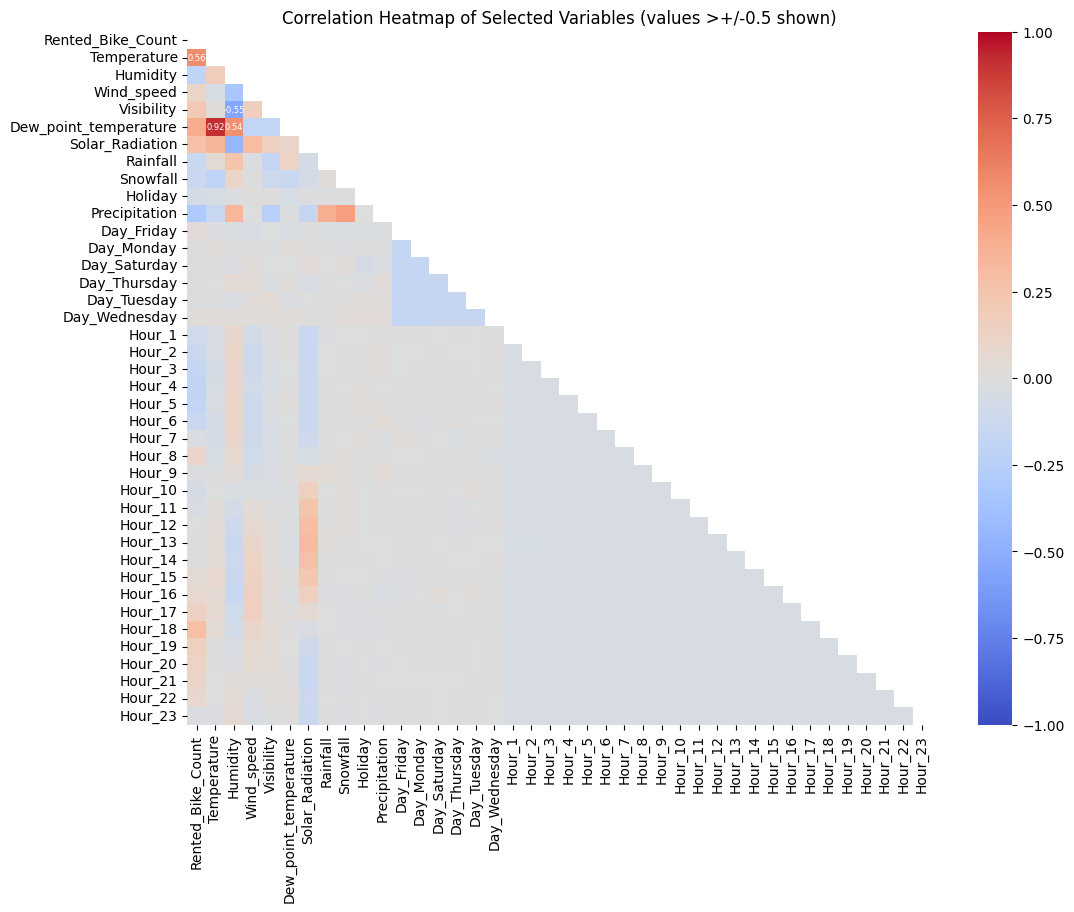

In [18]:
correlation_matrix = bike_df_dummy.corr()
rounded_correlation_matrix = correlation_matrix.round(2)

# Create a custom mask where correlations less than ±0.5 are not shown
mask = np.abs(rounded_correlation_matrix) < 0.5

# Create the heatmap with only significant correlations displayed
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix,
            cmap='coolwarm',  # color palette
            annot=rounded_correlation_matrix.where(~mask).fillna(''),  # only show values > ±0.5
            fmt="",  # format the annotation to 2 decimal places
            vmin=-1,  # start color legend at -1
            vmax=1,  # end color legend at 1
            mask=np.triu(correlation_matrix),
            annot_kws={"size": 6})  # remove the upper half of the plot
plt.title("Correlation Heatmap of Selected Variables (values >+/-0.5 shown)")

plt.show()



Either `Dew Point Temperature` or `Temperature` will definitely need to be removed based on the correlation value of 0.92. `Humidity` and `Visibility` have a high value that we should keep in mind in the upcoming steps.

### Selection Methods

Sequential Replacement and Backwards Stepwise Selection will be used to determine which variables should be removed (Best Subsets is not computationally plausible).

#### Sequential Replacement

In [19]:
seqrep_selection = SFS(LinearRegression(fit_intercept = True),
                                        k_features = (1, len(X.columns)),
                                        forward = True,
                                        floating = True,
                                        scoring = 'neg_mean_squared_error',
                                        cv = 5)

seqrep = seqrep_selection.fit(X, y)

print('Sequential Replacement Stepwise Selection:', seqrep.k_feature_names_)

Sequential Replacement Stepwise Selection: ('Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Solar_Radiation', 'Rainfall', 'Snowfall', 'Holiday', 'Precipitation', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23')


In [20]:
# Code to see the next best models
seqrep_results = pd.DataFrame.from_dict(seqrep.get_metric_dict()).T
seqrep_results['missing_features'] = seqrep_results['feature_names'].apply(lambda x: [col for col in X.columns if col not in x])
seqrep_results_sorted = seqrep_results.sort_values(by = 'avg_score', ascending = False)
seqrep_results_sorted[['missing_features','std_dev']].head(15)

missing_features      std_dev
37                    [Dew_point_temperature, Hour_9]  5230.304404
38                            [Dew_point_temperature]  5344.897024
35  [Dew_point_temperature, Hour_12, Hour_13, Hour...  5493.476962
34  [Dew_point_temperature, Hour_1, Hour_12, Hour_...  5520.913622
36          [Dew_point_temperature, Hour_12, Hour_15]  5376.756829
33  [Dew_point_temperature, Hour_1, Hour_10, Hour_...  5573.969762
32  [Wind_speed, Dew_point_temperature, Hour_1, Ho...  5857.374961
39                                                 []  5432.826142
31  [Wind_speed, Dew_point_temperature, Day_Saturd...  6054.465006
30  [Wind_speed, Dew_point_temperature, Day_Saturd...  5742.809293
29  [Wind_speed, Dew_point_temperature, Day_Monday...  6001.001693
28  [Wind_speed, Dew_point_temperature, Day_Monday...  6104.228572
27  [Wind_speed, Dew_point_temperature, Day_Monday...    6089.6663
26  [Wind_speed, Dew_point_temperature, Day_Monday...  6193.715188
25  [Wind_speed, Visibility, Dew_point_temperature...  5867.066821

#### Backward Stepwise Selection

In [21]:
backward_selection = SFS(LinearRegression(fit_intercept = True),
                         k_features = (1, len(X.columns)),
                         forward = False,
                         floating = False,
                         scoring = 'neg_mean_squared_error',
                         cv = 5)

backward = backward_selection.fit(X, y)

print('Backward Stepwise Selection:', backward.k_feature_names_)

Backward Stepwise Selection: ('Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Solar_Radiation', 'Rainfall', 'Snowfall', 'Holiday', 'Precipitation', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 'Hour_23')


In [22]:
backward_results = pd.DataFrame.from_dict(backward.get_metric_dict()).T
backward_results_sorted = backward_results.sort_values(by = 'avg_score', ascending = False)
# add a missing_features column that indicates what features are not present in the feature_names column given the X.column_names_
backward_results_sorted['missing_features'] = backward_results_sorted['feature_names'].apply(lambda x: [col for col in X.columns if col not in x])
backward_results_sorted[['missing_features','std_dev']].head(15)

missing_features      std_dev
37                    [Dew_point_temperature, Hour_9]  5230.304404
38                            [Dew_point_temperature]  5344.897024
36           [Dew_point_temperature, Hour_9, Hour_16]  5287.908222
35  [Wind_speed, Dew_point_temperature, Hour_9, Ho...  5544.034504
34  [Wind_speed, Visibility, Dew_point_temperature...  5295.360484
39                                                 []  5432.826142
33  [Wind_speed, Visibility, Dew_point_temperature...  5398.588404
32  [Wind_speed, Visibility, Dew_point_temperature...  5366.285955
31  [Wind_speed, Visibility, Dew_point_temperature...  5607.162315
30  [Wind_speed, Visibility, Dew_point_temperature...  5892.107155
29  [Wind_speed, Visibility, Dew_point_temperature...  5492.028884
28  [Wind_speed, Visibility, Dew_point_temperature...  5536.688482
27  [Wind_speed, Visibility, Dew_point_temperature...  5475.068059
26  [Wind_speed, Visibility, Dew_point_temperature...  5193.849535
25  [Wind_speed, Visibility, Dew_point_temperature...  4908.256181

Based on both of the selection methods, the following variables will be removed:

* `Dew_point_temperature`
* `Wind speed`
* `Visibility`

### Shrinkage Method

To further determine which variables are unnecessary for our analysis, Elastic Net will also be used for variable selection.

#### Elastic Net

In [23]:
# Create a list of possible alphas
potential_alphas = np.logspace(-4, 2, 500)

# run cross-validation to find the best alpha and l1_ratio
ElasticNetCV_model = ElasticNetCV(alphas = potential_alphas,
                                  cv = 5,
                                  random_state = 12345,
                                  max_iter = 10000,
                                  fit_intercept = True)
ElasticNetCV_model.fit(X, y)

# Get the list of alphas and corresponding MSEs
alphas = ElasticNetCV_model.alphas_
pmse_means = np.mean(ElasticNetCV_model.mse_path_, axis = 1)
pmse_std_error = np.std(ElasticNetCV_model.mse_path_,
                        axis = 1,
                        ddof = 1) / np.sqrt(5)  # 5-fold CV

# Find the alpha that minimizes MSE
alpha_index_min = np.argmin(pmse_means)
alpha_min = alphas[alpha_index_min]

# Find the MSE that is one standard error away from the minimum MSE
one_se_above_min = min(pmse_means) + pmse_std_error[alpha_index_min]

# Find the largetst alpha with MSE less than or equal to one_se_above_min
alpha_index_1se = np.where(pmse_means <= one_se_above_min)[0][0]
alpha_1se = alphas[alpha_index_1se]

print("Minimum alpha:", alpha_min)
print("One SE alpha:", alpha_1se)

Minimum alpha: 0.0006945177773823696
One SE alpha: 0.015009032755797366


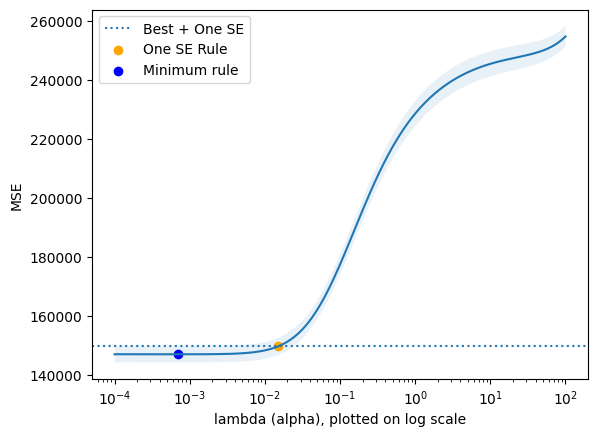

In [24]:
plt.plot(alphas,
         pmse_means)
plt.fill_between(alphas,
                 pmse_means + pmse_std_error,
                 pmse_means - pmse_std_error,
                 alpha = 0.1)
plt.axhline(one_se_above_min,
            linestyle = 'dotted',
            label = 'Best + One SE')
plt.scatter([alpha_1se],
            [pmse_means[alpha_index_1se]],
            marker = 'o',
            color = 'orange',
            label = 'One SE Rule')
plt.scatter([alpha_min],
            [pmse_means[alpha_index_min]],
            marker = 'o',
            color = 'blue',
            label = 'Minimum rule')
plt.legend()
plt.xscale('log')
plt.xlabel('lambda (alpha), plotted on log scale')
plt.ylabel('MSE')
plt.show()

In [25]:
en_1se = ElasticNet(alpha=alpha_1se, fit_intercept=True)
en_1se.fit(X, y)

# Get coefficients and feature names
coefficients = en_1se.coef_
feature_names = X.columns

# Create a DataFrame with feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of coefficients in descending order
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=True).index)
coef_df

c:\Users\04drm\Projects\DATA_5600\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.725e+05, tolerance: 2.086e+05
  model = cd_fast.enet_coordinate_descent(


Feature  Coefficient
3              Visibility     0.031382
4   Dew_point_temperature    -0.175916
2              Wind_speed    -3.160495
1                Humidity    -5.608837
24                 Hour_9    16.811689
5         Solar_Radiation    23.901443
0             Temperature    29.627418
31                Hour_16    31.051772
38                Hour_23    34.416582
6                Rainfall   -36.211208
12           Day_Saturday    41.390766
14            Day_Tuesday    54.661669
11             Day_Monday    56.873123
22                 Hour_7    80.973063
7                Snowfall    87.721700
30                Hour_15   -88.994358
13           Day_Thursday    95.131128
15          Day_Wednesday   104.115818
8                 Holiday  -108.229479
10             Day_Friday   126.900409
27                Hour_12  -133.034942
28                Hour_13  -133.497925
29                Hour_14  -140.368917
16                 Hour_1  -144.855558
25                Hour_10  -166.821163
26                Hour_11  -175.339200
21                 Hour_6  -190.553157
17                 Hour_2  -234.453959
32                Hour_17   252.342759
37                Hour_22   255.506707
9           Precipitation  -264.021118
18                 Hour_3  -279.254087
35                Hour_20   335.184241
36                Hour_21   338.152864
20                 Hour_5  -353.315454
19                 Hour_4  -359.243228
34                Hour_19   372.318838
23                 Hour_8   388.751598
33                Hour_18   636.805237

`Visibility`, `Dew_point_temperature`, and `Wind_Speed` all have the lowest values, matching the conclusion identified with the selection values.

### Choosing Subset

In [26]:
subset_columns = list(X.columns)
subset_columns.remove('Wind_speed')
subset_columns.remove('Dew_point_temperature')
subset_columns.remove('Visibility')
subset_columns

['Temperature',
 'Humidity',
 'Solar_Radiation',
 'Rainfall',
 'Snowfall',
 'Holiday',
 'Precipitation',
 'Day_Friday',
 'Day_Monday',
 'Day_Saturday',
 'Day_Thursday',
 'Day_Tuesday',
 'Day_Wednesday',
 'Hour_1',
 'Hour_2',
 'Hour_3',
 'Hour_4',
 'Hour_5',
 'Hour_6',
 'Hour_7',
 'Hour_8',
 'Hour_9',
 'Hour_10',
 'Hour_11',
 'Hour_12',
 'Hour_13',
 'Hour_14',
 'Hour_15',
 'Hour_16',
 'Hour_17',
 'Hour_18',
 'Hour_19',
 'Hour_20',
 'Hour_21',
 'Hour_22',
 'Hour_23']

## Initial Linear Regression

should we just remove snowfall? then we don't have to transform it and it's already the next option to be removed for all selection methods and not significant below

In [27]:
y = bike_df_dummy['Rented_Bike_Count']
X_subset = sm.add_constant(bike_df_dummy[subset_columns]) # column names from subset
mod = sm.OLS(y, X_subset)
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     260.8
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:39:19   Log-Likelihood:                -36794.
No. Observations:                5000   AIC:                         7.366e+04
Df Residuals:                    4963   BIC:                         7.390e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             519.1092     37.313     13.912      0.000     445.959     592.260
Temperature        28.4160      0.583     48.726      0.000      27.273      29.559
Humidity           -5.2404      0.378    -13.865      0.000      -5.981      -4.499
Solar_Radiation    57.1121     12.799      4.462      0.000      32.020      82.204
Rainfall          -34.3790      5.192     -6.621      0.000     -44.559     -24.200
Snowfall           99.9393     13.583      7.358      0.000      73.311     126.567
Holiday          -122.1547     25.375     -4.814      0.000    -171.900     -72.409
Precipitation    -305.7318     22.684    -13.478      0.000    -350.202    -261.262
Day_Friday        156.7885     19.786      7.924      0.000     118.000     195.577
Day_Monday         82.4004     19.848      4.152      0.000      43.490     121.311
Day_Saturday       65.0520     20.178      3.224      0.001      25.494     104.610
Day_Thursday      124.2522     20.075      6.189      0.000      84.897     163.608
Day_Tuesday        86.3347     20.353      4.242      0.000      46.434     126.235
Day_Wednesday     137.0093     20.092      6.819      0.000      97.620     176.398
Hour_1           -105.0012     37.973     -2.765      0.006    -179.445     -30.558
Hour_2           -208.0865     37.681     -5.522      0.000    -281.958    -134.215
Hour_3           -267.8847     38.870     -6.892      0.000    -344.088    -191.682
Hour_4           -365.8599     38.818     -9.425      0.000    -441.960    -289.760
Hour_5           -354.5664     38.770     -9.145      0.000    -430.574    -278.559
Hour_6           -162.9542     38.510     -4.231      0.000    -238.451     -87.458
Hour_7            152.8001     39.047      3.913      0.000      76.250     229.350
Hour_8            513.0551     39.099     13.122      0.000     436.403     589.707
Hour_9             59.4768     39.203      1.517      0.129     -17.379     136.333
Hour_10          -171.0541     41.724     -4.100      0.000    -252.851     -89.257
Hour_11          -184.2710     42.286     -4.358      0.000    -267.171    -101.371
Hour_12          -138.5978     43.344     -3.198      0.001    -223.572     -53.624
Hour_13          -139.2865     43.152     -3.228      0.001    -223.883     -54.690
Hour_14          -143.2130     43.014     -3.329      0.001    -227.539     -58.887
Hour_15           -73.0030     41.685     -1.751      0.080    -154.724       8.718
Hour_16            74.7935     40.577      1.843      0.065      -4.755     154.342
Hour_17           348.9732     39.771      8.775      0.000     271.004     426.942
Hour_18           810.5066     38.351     21.134      0.000     735.321     885.692
Hour_19           507.7543     38.366     13.234      0.000     432.539     582.969
Hour_20           467.8874     38.365     12.196      0.000

## Linear Assumptions

Now that we've determined a subset for our model, we can check linear assumptions. We will then transform any variables that do not meet linear assumptions.

### Linear
Are the Xs vs Y linear?

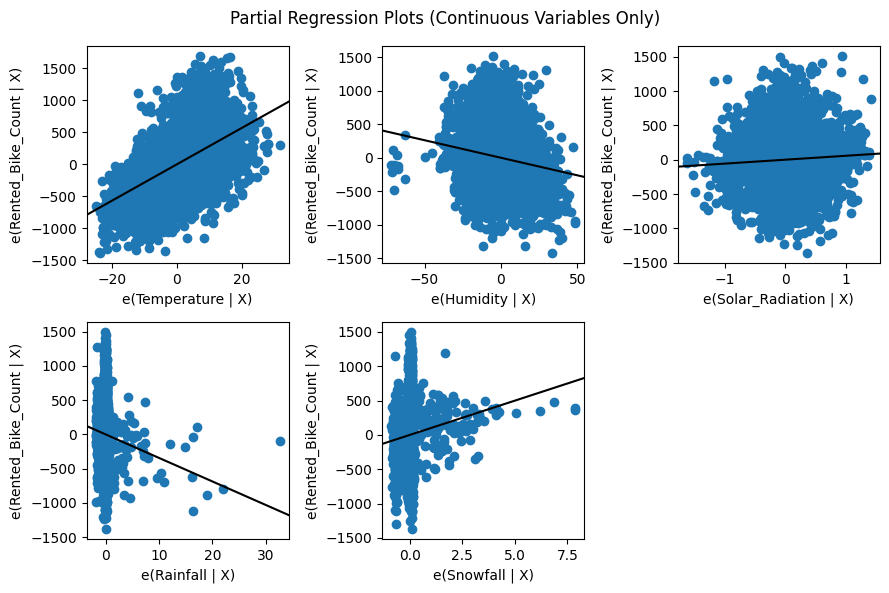

In [28]:
continuous_columns = bike_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
continuous_columns = [col for col in continuous_columns if col in subset_columns]

# Plot partial regression plots, excluding categorical variables
fig = plt.figure(figsize=(9,6))
sm.graphics.plot_partregress_grid(res,
                                  exog_idx=continuous_columns,
                                  grid=(2,3),
                                  fig=fig
                                  )

fig.suptitle('Partial Regression Plots (Continuous Variables Only)')
fig.tight_layout()
plt.show()

`Rainfall` and `Snowfall` are both extremely right-skewed, and break the assumption that the residuals are normally distributed. However, the linear assumption is met.

### Normal
Are the residuals normally distributed and centered at zero?

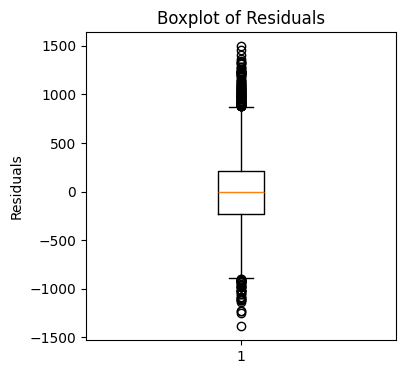

In [29]:
# Diagnostic 1
fig = plt.figure(figsize = (4, 4))
plt.boxplot(res.resid)
plt.ylabel("Residuals")
plt.title("Boxplot of Residuals")
plt.show()

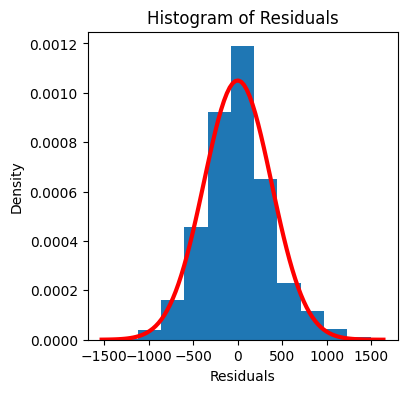

In [30]:
# Diagnostic 2
fig = plt.figure(figsize = (4, 4))

plt.hist(res.resid,
         density = True,
         bins = 11)
plt.xlabel("Residuals")
plt.ylabel("Density")

mean = np.mean(res.resid)
sd = np.std(res.resid)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

plt.plot(x,
         stats.norm.pdf(x, mean, sd),
         color = 'r',
         lw = 3)
plt.title("Histogram of Residuals")
plt.show()

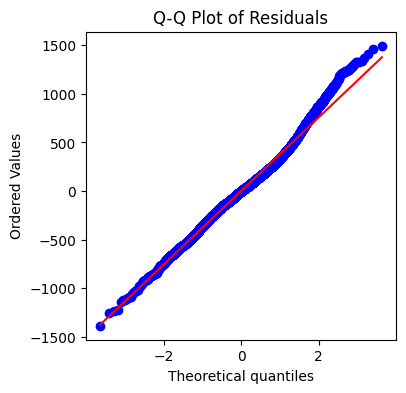

In [31]:
# Diagnostic 3
fig = plt.figure(figsize = (4, 4))
stats.probplot(res.resid,
               plot = plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

The boxplot and histogram look really promising. Both  depict the residuals as normally distributed. The dataset as a whole meets the assumption that the residuals are normally distribute, however, as mentioned in the *Linear* section, 2 variables do not and they will be investigated later.


### Equal/Constant Variance
Do the residuals have equal/constant variance across all values of X?

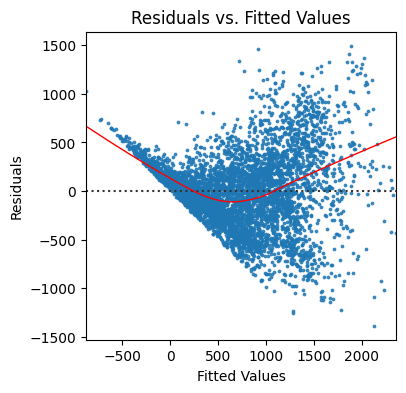

In [32]:
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = res.fittedvalues,
              y = res.resid,
              lowess = True,
              scatter_kws = {'s': 3},
              line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted Values")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

A distinct line shows where the *Fitted Values* value can't exist below the same value of the negative *Residual*. Otherwise, the shape is generally cloud-like and homoscedastic.

However, based on the partial regression plots for `Rainfall` and `Snowfall` do not exhibit constant variance, so the assumption is *not* met.

### Influential Points
Does the model describe all observations?

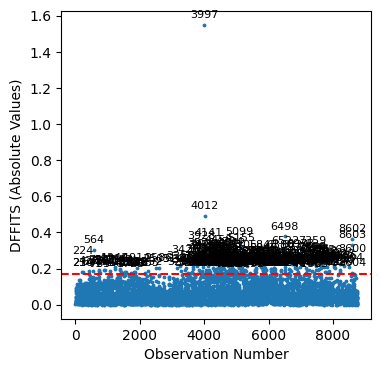

In [33]:
# DFFITS
bike_df_dummy['res_dffits'] = res.get_influence().dffits[0]

fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFFITS (Absolute Values)")
plt.xlabel("Observation Number")
plt.scatter(bike_df_dummy.index,
            np.abs(bike_df_dummy['res_dffits']),
            s = 3)
threshold = 2 * np.sqrt(len(res.params) / len(bike_df_dummy))
plt.axhline(y = threshold,
            color = 'r',
            linestyle = 'dashed')
influential_points = bike_df_dummy[np.abs(bike_df_dummy['res_dffits']) > threshold]
for i in influential_points.index:
    plt.annotate(str(i),
                 (i, np.abs(bike_df_dummy['res_dffits'][i])),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='center',
                 fontsize=8)
plt.show()


In [34]:
outlier_indicies = [3997, 4012, 6498, 8602, 564]
bike_df_dummy.loc[outlier_indicies][['Rented_Bike_Count']+subset_columns]

Rented_Bike_Count  Temperature  Humidity  Solar_Radiation  Rainfall  \
3997                151         21.8        97             0.06      35.0   
4012                 51         19.2        98             0.00      19.0   
6498                 96         24.3        97             0.01      18.5   
8602                 62          0.4        97             0.00       0.0   
564                   4          4.1        91             0.07       9.5   

      Snowfall  Holiday  Precipitation  Day_Friday  Day_Monday  ...  Hour_14  \
3997       0.0      0.0              1           0           0  ...        0   
4012       0.0      0.0              1           0           0  ...        0   
6498       0.0      0.0              1           0           0  ...        0   
8602       8.8      0.0              1           0           0  ...        0   
564        0.0      1.0              1           0           0  ...        0   

      Hour_15  Hour_16  Hour_17  Hour_18  Hour_19  Hour_20  Hour_21  Hour_22  \
3997        0        0        0        0        0        0        0        0   
4012        0        0        0        0        0        0        0        0   
6498        0        0        0        1        0        0        0        0   
8602        0        0        0        0        0        0        0        0   
564         0        0        0        0        0        0        0        0   

      Hour_23  
3997        0  
4012        0  
6498        0  
8602        0  
564         0  

[5 rows x 37 columns]

The biggest outlier found with DFBETAS and DFFITS was observation `3997`. It appears that there was an extreme of rain that hour, but 35mm for the hour is a possible observation so no action will be taken to remove it and the assumption the model describes all observations is met.

### Multicollinearity
Is there any multicollinearity among the variables?

In [35]:
# Variance Inflation Factors (VIF)
env_vifs = pd.DataFrame()
env_vifs['Feature'] = X_subset.columns[1:]
env_vifs['VIF'] = [vif(X_subset, i) for i in range(1, len(X_subset.columns))]

print("Max = ", max(env_vifs['VIF']))
print("Mean = ", np.mean(env_vifs['VIF']))
env_vifs.sort_values(by = 'VIF', ascending=False)

Max =  4.171058615760434
Mean =  2.044229346121867


Feature       VIF
2   Solar_Radiation  4.171059
25          Hour_13  2.752592
24          Hour_12  2.600201
26          Hour_14  2.514029
23          Hour_11  2.497341
27          Hour_15  2.426806
28          Hour_16  2.309849
21           Hour_9  2.223743
22          Hour_10  2.200112
30          Hour_18  2.128150
29          Hour_17  2.109292
14           Hour_2  2.107756
33          Hour_21  2.073898
13           Hour_1  2.068226
31          Hour_19  2.065050
32          Hour_20  2.055688
35          Hour_23  2.053373
1          Humidity  2.042612
18           Hour_6  2.033831
20           Hour_8  2.028950
17           Hour_5  1.994974
16           Hour_4  1.990329
15           Hour_3  1.986140
19           Hour_7  1.984942
34          Hour_22  1.950746
6     Precipitation  1.760281
7        Day_Friday  1.714972
0       Temperature  1.714516
8        Day_Monday  1.699134
10     Day_Thursday  1.678970
9      Day_Saturday  1.678168
12    Day_Wednesday  1.675836
11      Day_Tuesday  1.649322
4          Snowfall  1.377807
3          Rainfall  1.261509
5           Holiday  1.012054

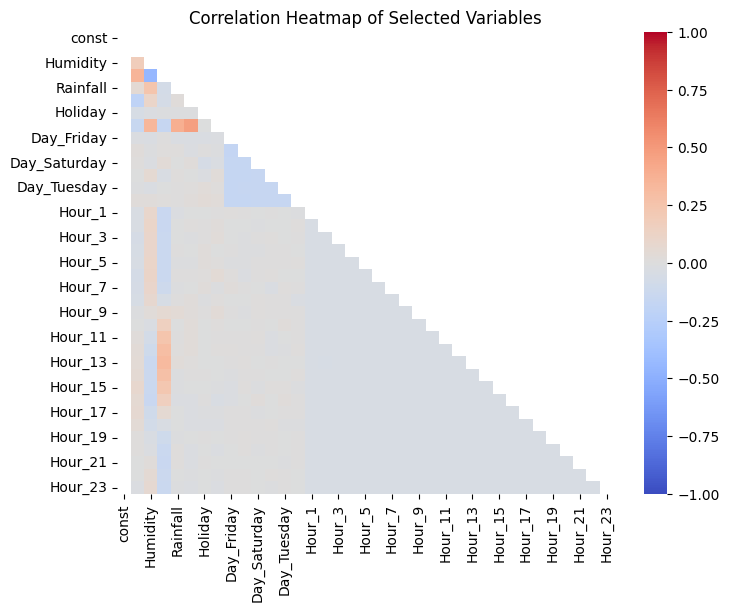

In [36]:
correlation_matrix = X_subset.corr()
rounded_correlation_matrix = correlation_matrix.round(2)

# Create a custom mask where correlations less than ±0.5 are not shown
mask = np.abs(rounded_correlation_matrix) < 0.5

# Create the heatmap with only significant correlations displayed
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            cmap='coolwarm',  # color palette
            annot=rounded_correlation_matrix.where(~mask).fillna(''),  # only show values > ±0.5
            fmt="",  # format the annotation to 2 decimal places
            vmin=-1,  # start color legend at -1
            vmax=1,  # end color legend at 1
            mask=np.triu(correlation_matrix))  # remove the upper half of the plot
plt.title("Correlation Heatmap of Selected Variables")
plt.show()


The VIF and the correlation values both look promising with the highest variable being `Solar Radiation` with a value of 4.17. While a value above 4 is not ideal, because it doesn't show up to be taken out in our variable selection, we will continue with the relatively high value. In the correlation matrix, there isn't a single value over 0.5. Therefore, the assumption of no multicollinearity is met.

### Linear Assumptions Conclusion

1.   **Are the X's and Y linear?** Met

2.   **Are the residuals independant?** Met

While there was a data column identifying the time and hour, both were used as categorical varaibles with `Date` converted  to `Day` and making `Hour` a categorical variable. Otherwise, the residuals were collected in a way that would facilitate independance.

3.   **Are the residuals normally distibuted and centered at zero?** Met

4.   **Do the residuals have equal/constant variance across all values of X?** *Not* met

5.   **Are there any influential points? Does the model describe all observations?** Met

6.   **Are any additional predictor variables required?** Met

We have a lot of predictor variables and it seems unlikely that there would be other variables that are needed for the model. Most possible weather variables are included as well as date variables to act as predictors.

7.   **Is there any multicollinearity present?** Met




## Transformations

In order to meet the linear assumptions necessary for multiple linear regression, the variables `Snowfall` and `Rainfall` both need to be transformed.


### Finding the Best Transformations

In [37]:
subset_columns.remove('Snowfall')
subset_columns.remove('Rainfall')
subset_columns

['Temperature',
 'Humidity',
 'Solar_Radiation',
 'Holiday',
 'Precipitation',
 'Day_Friday',
 'Day_Monday',
 'Day_Saturday',
 'Day_Thursday',
 'Day_Tuesday',
 'Day_Wednesday',
 'Hour_1',
 'Hour_2',
 'Hour_3',
 'Hour_4',
 'Hour_5',
 'Hour_6',
 'Hour_7',
 'Hour_8',
 'Hour_9',
 'Hour_10',
 'Hour_11',
 'Hour_12',
 'Hour_13',
 'Hour_14',
 'Hour_15',
 'Hour_16',
 'Hour_17',
 'Hour_18',
 'Hour_19',
 'Hour_20',
 'Hour_21',
 'Hour_22',
 'Hour_23']

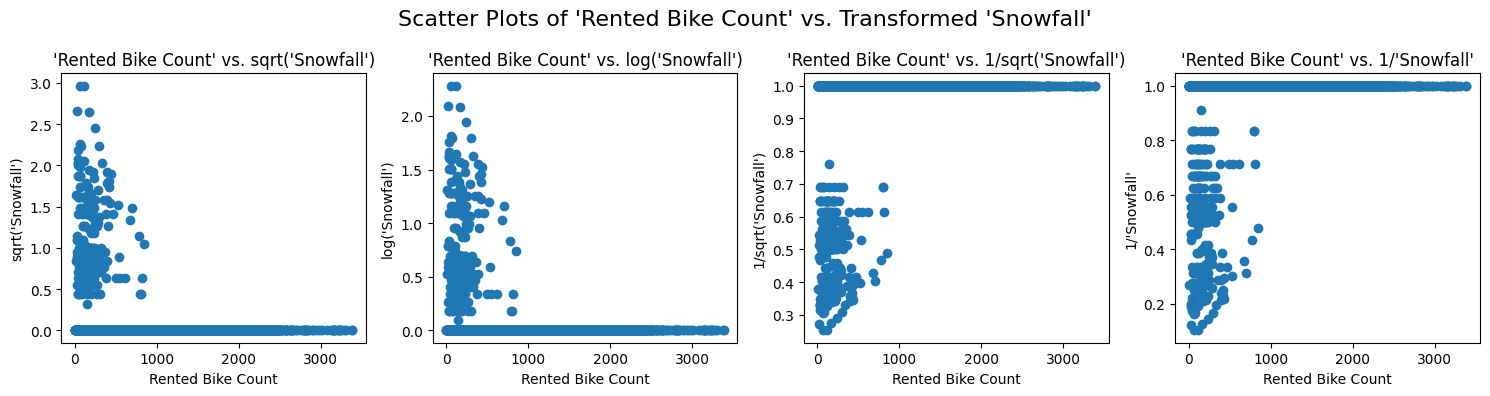

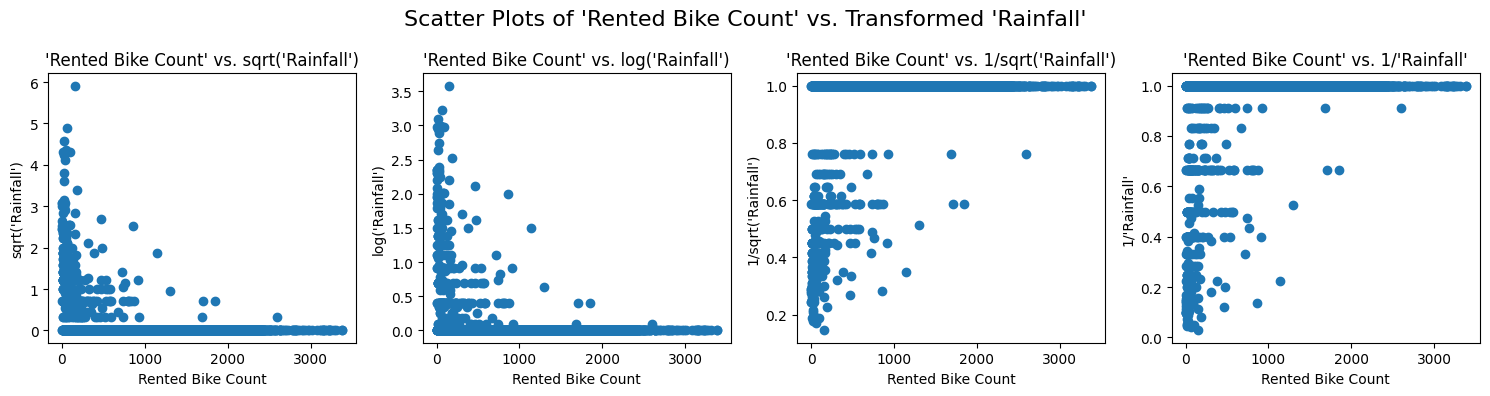

In [38]:
# go through the transformations √(X), log(X), log(log(X)), 1/√(X), 1/X and print the scatter plot of variable vs. the dependent variable ('Rented Bike Count')

def transform_and_plot(df, variable):
    # Transformations
    transformations = {
        f'sqrt(\'{variable}\')': np.sqrt(df[variable]),
        f'log(\'{variable}\')': np.log(df[variable]+1),
        f'1/sqrt(\'{variable}\')': 1 / (np.sqrt(df[variable])+1),
        f'1/\'{variable}\'': 1 / (df[variable]+1)
    }

    # Create subplots
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes = axes.ravel()  # Flatten the axes array for easier iteration

    # Iterate through transformations and create plots
    for i, (name, transformed_y) in enumerate(transformations.items()):
        axes[i].scatter(df['Rented_Bike_Count'], transformed_y)
        axes[i].set_xlabel('Rented Bike Count')
        axes[i].set_ylabel(name)
        axes[i].set_title(f'\'Rented Bike Count\' vs. {name}')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Scatter Plots of \'Rented Bike Count\' vs. Transformed \'{variable}\'', fontsize=16)
    plt.tight_layout()
    plt.show()

transform_and_plot(bike_df_dummy, 'Snowfall')
transform_and_plot(bike_df_dummy, 'Rainfall')

Although none of the transformations could completely get rid of the extreme right skew, the log(var+1) looks like the best option for both variables.

In [39]:
# now add the transformed columns to the dataframe and the names to the subset of columns variable
bike_df_dummy['Snowfall_log'] = np.log(bike_df_dummy['Snowfall']+1)
bike_df_dummy['Rainfall_log'] = np.log(bike_df_dummy['Rainfall']+1)
subset_columns.append("Snowfall_log")
subset_columns.append("Rainfall_log")
subset_columns

['Temperature',
 'Humidity',
 'Solar_Radiation',
 'Holiday',
 'Precipitation',
 'Day_Friday',
 'Day_Monday',
 'Day_Saturday',
 'Day_Thursday',
 'Day_Tuesday',
 'Day_Wednesday',
 'Hour_1',
 'Hour_2',
 'Hour_3',
 'Hour_4',
 'Hour_5',
 'Hour_6',
 'Hour_7',
 'Hour_8',
 'Hour_9',
 'Hour_10',
 'Hour_11',
 'Hour_12',
 'Hour_13',
 'Hour_14',
 'Hour_15',
 'Hour_16',
 'Hour_17',
 'Hour_18',
 'Hour_19',
 'Hour_20',
 'Hour_21',
 'Hour_22',
 'Hour_23',
 'Snowfall_log',
 'Rainfall_log']

### Linear Regression After Transformation

In [40]:
X_subset_trans = sm.add_constant(bike_df_dummy[subset_columns])

mod = sm.OLS(y, X_subset_trans)
res_trans = mod.fit()

res_trans.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     266.2
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:40:34   Log-Likelihood:                -36760.
No. Observations:                5000   AIC:                         7.359e+04
Df Residuals:                    4963   BIC:                         7.384e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             489.0899     37.213     13.143      0.000     416.135     562.045
Temperature        28.9304      0.583     49.587      0.000      27.787      30.074
Humidity           -4.8701      0.378    -12.886      0.000      -5.611      -4.129
Solar_Radiation    51.6667     12.726      4.060      0.000      26.718      76.615
Holiday          -121.9669     25.206     -4.839      0.000    -171.382     -72.551
Precipitation    -260.8422     29.112     -8.960      0.000    -317.915    -203.770
Day_Friday        158.4079     19.658      8.058      0.000     119.870     196.945
Day_Monday         84.7764     19.718      4.299      0.000      46.121     123.432
Day_Saturday       67.9168     20.039      3.389      0.001      28.632     107.201
Day_Thursday      119.2899     19.947      5.980      0.000      80.186     158.394
Day_Tuesday        84.8379     20.218      4.196      0.000      45.201     124.474
Day_Wednesday     131.3576     19.965      6.580      0.000      92.218     170.497
Hour_1           -107.2017     37.726     -2.842      0.005    -181.162     -33.241
Hour_2           -208.4258     37.432     -5.568      0.000    -281.809    -135.043
Hour_3           -263.3751     38.621     -6.820      0.000    -339.089    -187.661
Hour_4           -366.2829     38.560     -9.499      0.000    -441.877    -290.689
Hour_5           -356.4273     38.518     -9.254      0.000    -431.939    -280.915
Hour_6           -159.5245     38.258     -4.170      0.000    -234.528     -84.521
Hour_7            152.7409     38.789      3.938      0.000      76.698     228.784
Hour_8            514.6343     38.837     13.251      0.000     438.497     590.772
Hour_9             72.0602     38.965      1.849      0.064      -4.328     148.448
Hour_10          -159.2182     41.453     -3.841      0.000    -240.484     -77.952
Hour_11          -169.3317     42.016     -4.030      0.000    -251.701     -86.962
Hour_12          -118.7849     43.105     -2.756      0.006    -203.290     -34.280
Hour_13          -125.9206     42.855     -2.938      0.003    -209.936     -41.906
Hour_14          -128.7665     42.746     -3.012      0.003    -212.568     -44.965
Hour_15           -60.3220     41.423     -1.456      0.145    -141.529      20.885
Hour_16            86.3201     40.321      2.141      0.032       7.273     165.367
Hour_17           359.5858     39.523      9.098      0.000     282.103     437.068
Hour_18           818.3673     38.107     21.476      0.000     743.661     893.073
Hour_19           513.6195     38.115     13.475      0.000     438.897     588.342
Hour_20           468.0701     38.101     12.285      0.000     393.375     542.765
Hour_21           472.6948     37.776     12.513      0.000     398.638     546.752
Hour_22           378.4853     38.835      9.746      0.000

### Check Assumptions After Transformations

#### Linear
Are the Xs vs Y linear?

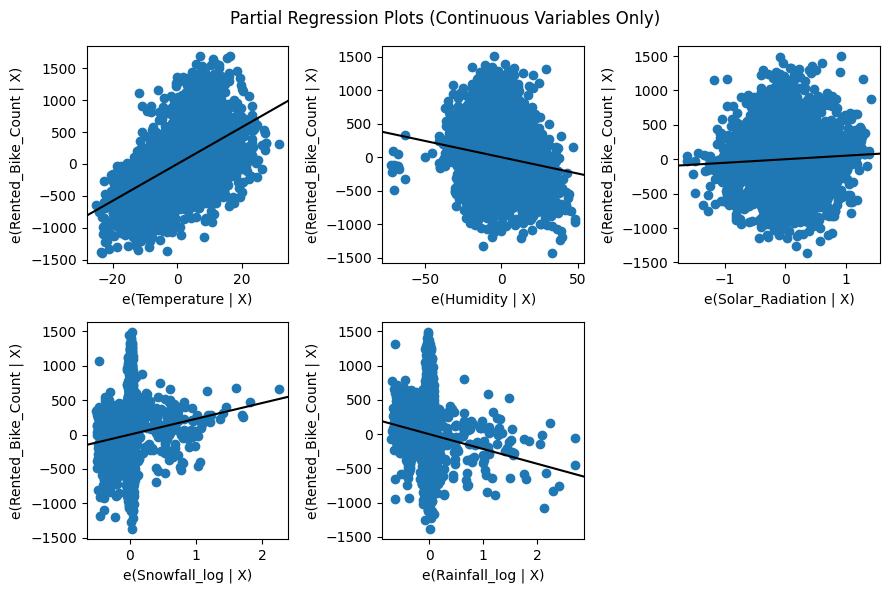

In [41]:
continuous_columns.remove('Snowfall')
continuous_columns.remove('Rainfall')
continuous_columns.append('Snowfall_log')
continuous_columns.append('Rainfall_log')

# Plot partial regression plots, excluding categorical variables
fig = plt.figure(figsize=(9,6))
sm.graphics.plot_partregress_grid(res_trans,
                                  exog_idx=continuous_columns,
                                  grid=(2,3),
                                  fig=fig
                                  )

fig.suptitle('Partial Regression Plots (Continuous Variables Only)')
fig.tight_layout()
plt.show()

The X's and Y still appear linear post transformation. The assumption is met.

The variance on `Snowfall_log` and `Rainfall_log` even looks better after the transformation.

#### Normal
Are the residuals normally distributed and centered at zero?

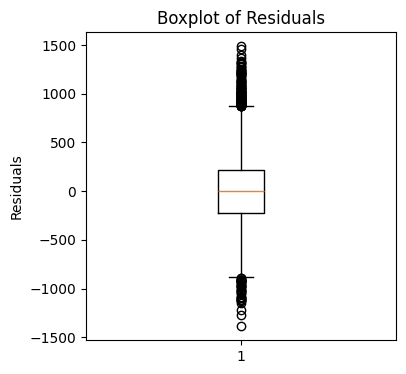

In [42]:
# Diagnostic 1
fig = plt.figure(figsize = (4, 4))
plt.boxplot(res_trans.resid)
plt.ylabel("Residuals")
plt.title("Boxplot of Residuals")
plt.show()

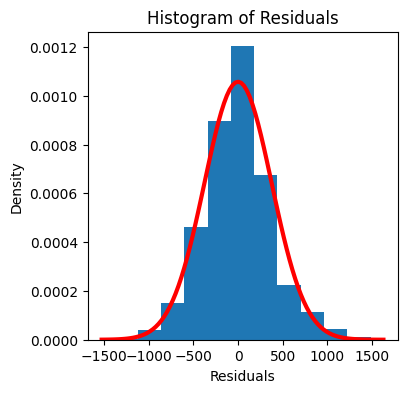

In [43]:
# Diagnostic 2
fig = plt.figure(figsize = (4, 4))

plt.hist(res_trans.resid,
         density = True,
         bins = 11)
plt.xlabel("Residuals")
plt.ylabel("Density")

mean = np.mean(res_trans.resid)
sd = np.std(res_trans.resid)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

plt.plot(x,
         stats.norm.pdf(x, mean, sd),
         color = 'r',
         lw = 3)
plt.title("Histogram of Residuals")
plt.show()

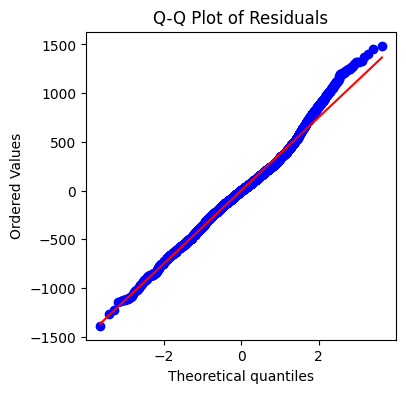

In [44]:
# Diagnostic 3
fig = plt.figure(figsize = (4, 4))
stats.probplot(res_trans.resid,
               plot = plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

Normality of the residuals is unchanged after the transformation. The assumption is met.

#### Equal/Constant Variance
Do the residuals have equal/constant variance across all values of X?

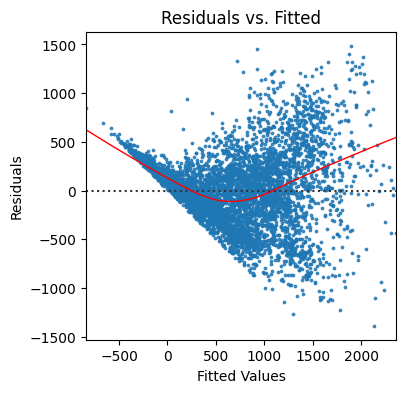

In [45]:
fig = plt.figure(figsize = (4, 4))
sns.residplot(x = res_trans.fittedvalues,
              y = res_trans.resid,
              lowess = True,
              scatter_kws = {'s': 3},
              line_kws = {'color': 'red', 'lw': 1})
plt.title("Residuals vs. Fitted")
plt.ylabel("Residuals")
plt.xlabel("Fitted Values")
plt.show()

Although the graph still look somewhat strange, it actually looks better post transformation, and the assumption is still met.

#### Influential Points
Does the model describe all observations?

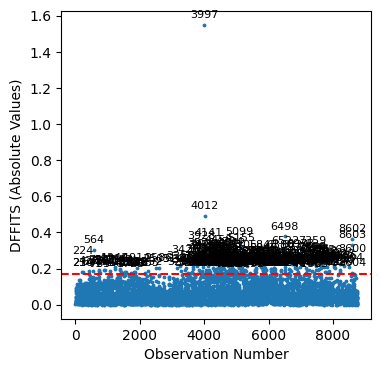

In [46]:
# DFFITS
bike_df_dummy['res_trans_dffits'] = res.get_influence().dffits[0]

fig = plt.figure(figsize = (4, 4))
plt.ylabel("DFFITS (Absolute Values)")
plt.xlabel("Observation Number")
plt.scatter(bike_df_dummy.index,
            np.abs(bike_df_dummy['res_trans_dffits']),
            s = 3)
threshold = 2 * np.sqrt(len(res.params) / len(bike_df_dummy))
plt.axhline(y = threshold,
            color = 'r',
            linestyle = 'dashed')
influential_points = bike_df_dummy[np.abs(bike_df_dummy['res_trans_dffits']) > threshold]
for i in influential_points.index:
    plt.annotate(str(i),
                 (i, np.abs(bike_df_dummy['res_trans_dffits'][i])),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='center',
                 fontsize=8)
plt.show()


Perhaps unsurprisingly, the spread of outliers is greater now that the transformations have been performed. Most of the high values are the same and don't necessitate any further investigation. Although we would like to see less outliers affecting the model, this is acceptable for our current model.

#### Multicollinearity
Is there any multicollinearity among the variables?

In [47]:
# Variance Inflation Factors (VIF)
env_vifs = pd.DataFrame()
env_vifs['Feature'] = X_subset_trans.columns[1:]
env_vifs['VIF'] = [vif(X_subset, i) for i in range(1, len(X_subset.columns))]

print("Max = ", max(env_vifs['VIF']))
print("Mean = ", np.mean(env_vifs['VIF']))
env_vifs.sort_values(by = 'VIF', ascending=False)

Max =  4.171058615760434
Mean =  2.044229346121867


Feature       VIF
2   Solar_Radiation  4.171059
25          Hour_15  2.752592
24          Hour_14  2.600201
26          Hour_16  2.514029
23          Hour_13  2.497341
27          Hour_17  2.426806
28          Hour_18  2.309849
21          Hour_11  2.223743
22          Hour_12  2.200112
30          Hour_20  2.128150
29          Hour_19  2.109292
14           Hour_4  2.107756
33          Hour_23  2.073898
13           Hour_3  2.068226
31          Hour_21  2.065050
32          Hour_22  2.055688
35     Rainfall_log  2.053373
1          Humidity  2.042612
18           Hour_8  2.033831
20          Hour_10  2.028950
17           Hour_7  1.994974
16           Hour_6  1.990329
15           Hour_5  1.986140
19           Hour_9  1.984942
34     Snowfall_log  1.950746
6        Day_Monday  1.760281
7      Day_Saturday  1.714972
0       Temperature  1.714516
8      Day_Thursday  1.699134
10    Day_Wednesday  1.678970
9       Day_Tuesday  1.678168
12           Hour_2  1.675836
11           Hour_1  1.649322
4     Precipitation  1.377807
3           Holiday  1.261509
5        Day_Friday  1.012054

The high multicollinearity values are nearly identical as `Solar Radiation`/`Hour_...` have not been touched.

#### Transformed Assumptions Conclusion

Now that the variables `Snowfall` and `Rainfall` were transformed, the assumptions all look much better. Although they are still very right skewed, all assumptions are assumed to be met now. No assumptions were made worse by transformation.

## Interactions

In order to find what variables should be included as interaction terms, the relationships that can be graphed will be and the combination of the rest of the variables will be considered.

### Plotting the Interactions

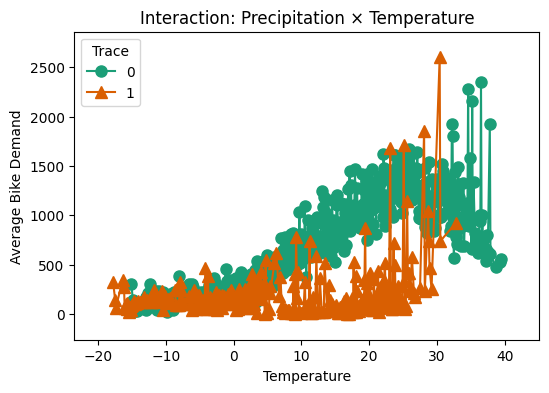

Temperature_Precipitation_Interaction:
   df_resid           ssr  df_diff       ss_diff          F        Pr(>F)
0    4963.0  7.118586e+08      0.0           NaN        NaN           NaN
1    4962.0  6.995468e+08      1.0  1.231179e+07  87.329527  1.354771e-20


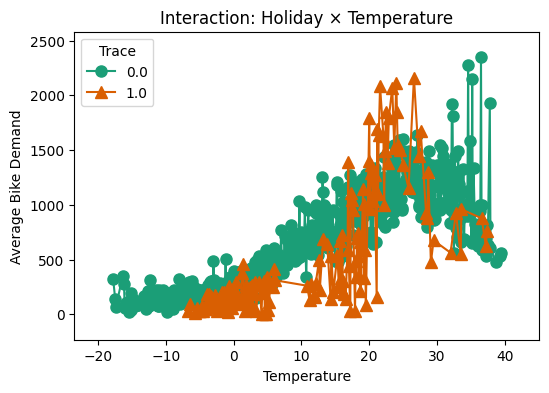

Temperature_Holiday_Interaction:
   df_resid           ssr  df_diff        ss_diff         F    Pr(>F)
0    4963.0  7.118586e+08      0.0            NaN       NaN       NaN
1    4962.0  7.111053e+08      1.0  753291.800479  5.256372  0.021908


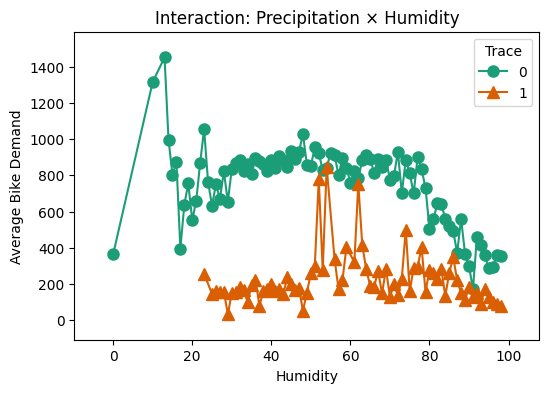

Humidity_Precipitation_Interaction:
   df_resid           ssr  df_diff       ss_diff          F    Pr(>F)
0    4963.0  7.118586e+08      0.0           NaN        NaN       NaN
1    4962.0  7.088517e+08      1.0  3.006886e+06  21.048362  0.000005


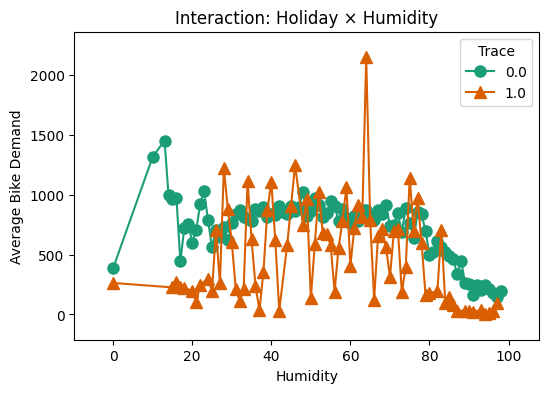

Humidity_Holiday_Interaction:
   df_resid           ssr  df_diff        ss_diff         F    Pr(>F)
0    4963.0  7.118586e+08      0.0            NaN       NaN       NaN
1    4962.0  7.114416e+08      1.0  417049.830854  2.908744  0.088163


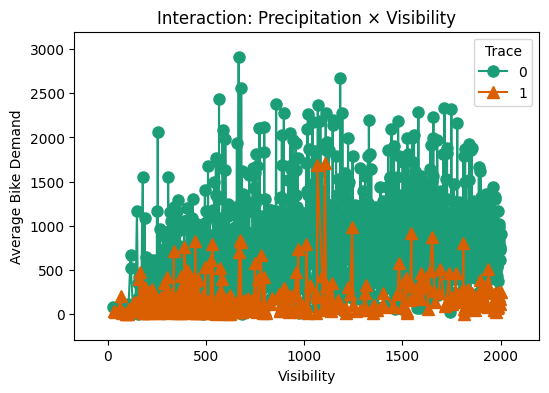

Visibility_Precipitation_Interaction:
   df_resid           ssr  df_diff        ss_diff         F    Pr(>F)
0    4963.0  7.118586e+08      0.0            NaN       NaN       NaN
1    4962.0  7.109996e+08      1.0  858984.436697  5.994772  0.014383


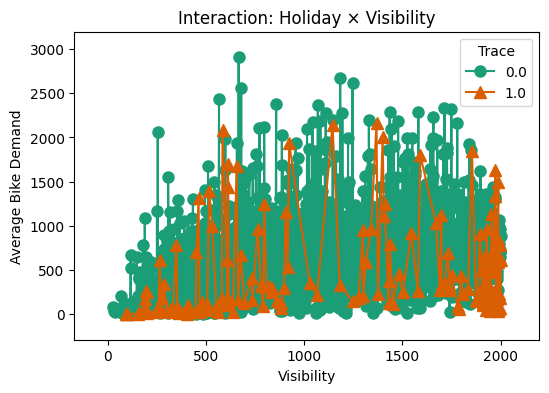

Visibility_Holiday_Interaction:
   df_resid           ssr  df_diff        ss_diff         F    Pr(>F)
0    4963.0  7.118586e+08      0.0            NaN       NaN       NaN
1    4962.0  7.112644e+08      1.0  594233.782483  4.145558  0.041797


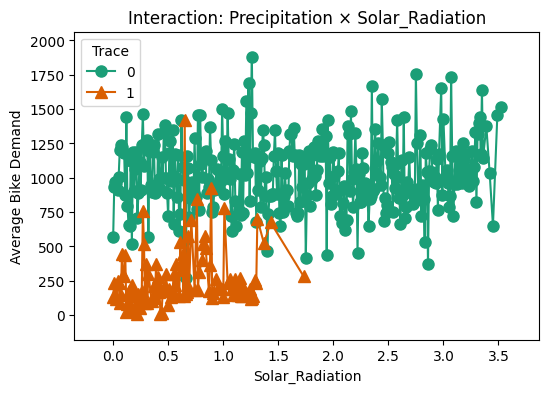

Solar_Radiation_Precipitation_Interaction:
   df_resid           ssr  df_diff       ss_diff          F    Pr(>F)
0    4963.0  7.118586e+08      0.0           NaN        NaN       NaN
1    4962.0  7.102290e+08      1.0  1.629592e+06  11.385108  0.000746


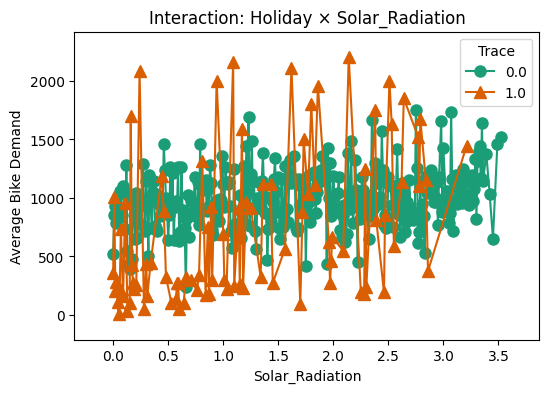

Solar_Radiation_Holiday_Interaction:
   df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0    4963.0  7.118586e+08      0.0           NaN       NaN       NaN
1    4962.0  7.104978e+08      1.0  1.360842e+06  9.503896  0.002062


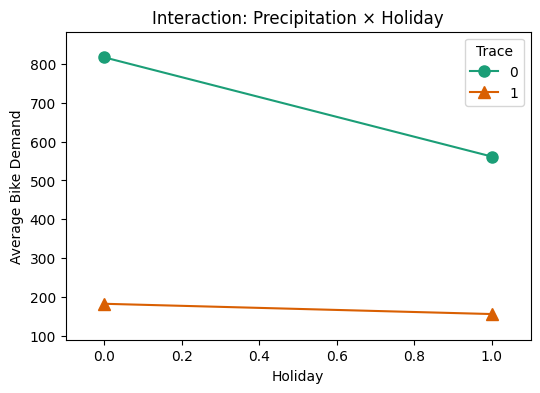

Holiday_Precipitation_Interaction:
   df_resid           ssr  df_diff       ss_diff         F   Pr(>F)
0    4963.0  7.118586e+08      0.0           NaN       NaN      NaN
1    4962.0  7.117689e+08      1.0  89661.310396  0.625062  0.42921


In [48]:
def make_interaction_plot(x, trace):
    fig, ax = plt.subplots(figsize=(6, 4))
    interaction_plot(
        x=bike_df_dummy[x].to_numpy(),
        trace=bike_df_dummy[trace].to_numpy(),
        response=bike_df_dummy["Rented_Bike_Count"].to_numpy(),
        colors=["#1b9e77", "#d95f02"],
        markers=["o", "^"],
        ms=8,
        ax=ax
    )
    ax.set_xlabel(x)
    ax.set_ylabel("Average Bike Demand")
    plt.title(" ".join(["Interaction:", trace, "×", x]))
    plt.show()

    interaction_column = "_".join([x,trace,"Interaction"])
    bike_df_dummy[interaction_column] = bike_df_dummy[x] * bike_df_dummy[trace]

    # Combine subset_columns and the interaction term into a single DataFrame
    X = pd.concat([bike_df_dummy[subset_columns], bike_df_dummy[interaction_column]], axis=1)

    # Fit the OLS model
    X = sm.add_constant(X)
    res_inter = sm.OLS(y, X).fit()
    print(interaction_column,":",sep="")
    print(anova_lm(res_trans, res_inter))

make_interaction_plot(x="Temperature", trace="Precipitation",)
make_interaction_plot(x="Temperature", trace="Holiday",)
make_interaction_plot(x="Humidity", trace="Precipitation",)
make_interaction_plot(x="Humidity", trace="Holiday",)
make_interaction_plot(x="Visibility", trace="Precipitation",)
make_interaction_plot(x="Visibility", trace="Holiday",)
make_interaction_plot(x="Solar_Radiation", trace="Precipitation",)
make_interaction_plot(x="Solar_Radiation", trace="Holiday",)
make_interaction_plot(x="Holiday", trace="Precipitation",)

### Testing All Interactions

A combination of all variables will be tested, but to maintain interpretability the combinations including the dummy coded categorical variables (`Hour`, `Day_Week`) will not be considered.

In [49]:
# functions to check all combinations of interactions against the model
def check_interactions(data, model, response_var):
    # Extract the list of variables from the model model's exogenous variables
    predictors = [col for col in model.model.exog_names if col != 'Intercept' and col != response_var and col != 'const']
    
    # Prepare an empty list to store interaction results
    interaction_results = []
    
    # Loop through all combinations of variables for pairwise interactions
    for var1, var2 in combinations(predictors, 2):
        # Define the interaction formula
        interaction_formula = f"{response_var} ~ {' + '.join(predictors)} + {var1}:{var2}"
        
        try:
            # Fit the model with the interaction term
            res_inter = sm.OLS.from_formula(interaction_formula, data=data).fit()
            
            # Perform ANOVA to compare the model with and without the interaction term
            anova_results = anova_lm(model, res_inter)
            
            # Extract the F-statistic and p-value for the interaction
            f_stat = anova_results["F"].iloc[-1]
            p_value = anova_results["Pr(>F)"].iloc[-1]
            
            # Append the result to the list
            interaction_results.append({
                "Interaction": f"{var1}:{var2}",
                "F-Statistic": f_stat,
                "p-Value": p_value
            })
            
        except Exception as e:
            print(f"Error with interaction {var1}:{var2} - {e}")
    
    # Convert the results into a DataFrame for easy viewing
    interaction_df = pd.DataFrame(interaction_results)
    
    # Sort by p-value to quickly identify significant interactions
    interaction_df = interaction_df.sort_values(by="p-Value").reset_index(drop=True)
    
    return interaction_df


In [50]:
interaction_combos = check_interactions(bike_df_dummy, res_trans, "Rented_Bike_Count")

# only the significant interactions are shown, p-value < 0.05
# to avoid complexity, we will ignore interactions that contain 'Hour' or 'Day'
significant_interactions = interaction_combos[(~interaction_combos['Interaction'].str.contains('Hour|Day')) & 
                                              (interaction_combos['p-Value'] < 0.05)].sort_values(by='p-Value', ascending=True)

significant_interactions

Interaction  F-Statistic       p-Value
1      Temperature:Solar_Radiation   179.743412  2.750770e-40
8        Temperature:Precipitation    87.329527  1.354771e-20
9             Temperature:Humidity    75.470694  4.964343e-18
26          Humidity:Precipitation    21.048362  4.588689e-06
35        Temperature:Rainfall_log    17.491176  2.936234e-05
47        Temperature:Snowfall_log    14.486984  1.428322e-04
55   Solar_Radiation:Precipitation    11.385108  7.460288e-04
57    Solar_Radiation:Rainfall_log    10.986434  9.243979e-04
65         Solar_Radiation:Holiday     9.503896  2.061618e-03
86            Holiday:Snowfall_log     6.582978  1.032496e-02
102            Temperature:Holiday     5.256372  2.190821e-02

### Picking Interactions to Include

Based on the p-value from the ANOVA test being less than 0.05 (and visually inspecting the graph), all of the above interactions will be included.


In [51]:
for interaction in significant_interactions['Interaction']:
    var1, var2 = interaction.split(':')
    bike_df_dummy[interaction] = bike_df_dummy[var1] * bike_df_dummy[var2]
    subset_columns.append(interaction)

subset_columns

['Temperature',
 'Humidity',
 'Solar_Radiation',
 'Holiday',
 'Precipitation',
 'Day_Friday',
 'Day_Monday',
 'Day_Saturday',
 'Day_Thursday',
 'Day_Tuesday',
 'Day_Wednesday',
 'Hour_1',
 'Hour_2',
 'Hour_3',
 'Hour_4',
 'Hour_5',
 'Hour_6',
 'Hour_7',
 'Hour_8',
 'Hour_9',
 'Hour_10',
 'Hour_11',
 'Hour_12',
 'Hour_13',
 'Hour_14',
 'Hour_15',
 'Hour_16',
 'Hour_17',
 'Hour_18',
 'Hour_19',
 'Hour_20',
 'Hour_21',
 'Hour_22',
 'Hour_23',
 'Snowfall_log',
 'Rainfall_log',
 'Temperature:Solar_Radiation',
 'Temperature:Precipitation',
 'Temperature:Humidity',
 'Humidity:Precipitation',
 'Temperature:Rainfall_log',
 'Temperature:Snowfall_log',
 'Solar_Radiation:Precipitation',
 'Solar_Radiation:Rainfall_log',
 'Solar_Radiation:Holiday',
 'Holiday:Snowfall_log',
 'Temperature:Holiday']

## Final Linear Regression Model

In [52]:
X_subset_trans_inters = sm.add_constant(bike_df_dummy[subset_columns]) # with transformations and interactions, without ommited variables

mod = sm.OLS(y, X_subset_trans_inters)
res_final = mod.fit()

res_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     239.6
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:42:35   Log-Likelihood:                -36483.
No. Observations:                5000   AIC:                         7.306e+04
Df Residuals:                    4952   BIC:                         7.338e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           148.4514     40.236      3.690      0.000      69.572     227.331
Temperature                      59.8691      1.895     31.591      0.000      56.154      63.584
Humidity                          0.4794      0.506      0.948      0.343      -0.512       1.471
Solar_Radiation                 292.8368     19.801     14.789      0.000     254.019     331.655
Holiday                        -198.3036     34.932     -5.677      0.000    -266.786    -129.822
Precipitation                    41.2258    120.682      0.342      0.733    -195.364     277.815
Day_Friday                      164.2460     18.682      8.792      0.000     127.622     200.870
Day_Monday                       84.5795     18.765      4.507      0.000      47.792     121.367
Day_Saturday                     48.0691     19.064      2.521      0.012      10.695      85.443
Day_Thursday                    123.4526     19.070      6.474      0.000      86.066     160.839
Day_Tuesday                      96.3353     19.359      4.976      0.000      58.383     134.288
Day_Wednesday                   142.5958     19.254      7.406      0.000     104.849     180.343
Hour_1                          -91.0219     35.762     -2.545      0.011    -161.131     -20.913
Hour_2                         -197.3343     35.469     -5.563      0.000    -266.870    -127.798
Hour_3                         -240.4850     36.605     -6.570      0.000    -312.248    -168.722
Hour_4                         -353.5815     36.551     -9.674      0.000    -425.238    -281.925
Hour_5                         -344.3330     36.512     -9.431      0.000    -415.912    -272.754
Hour_6                         -150.0368     36.258     -4.138      0.000    -221.118     -78.956
Hour_7                          159.6955     36.774      4.343      0.000      87.602     231.789
Hour_8                          504.3373     36.856     13.684      0.000     432.083     576.592
Hour_9                           31.7588     37.257      0.852      0.394     -41.281     104.798
Hour_10                        -219.3467     40.140     -5.465      0.000    -298.038    -140.655
Hour_11                        -234.4488     41.118     -5.702      0.000    -315.059    -153.839
Hour_12                        -203.9988     42.645     -4.784      0.000    -287.602    -120.395
Hour_13                        -210.9076     42.112     -5.008      0.000    -293.466    -128.349
Hour_14                        -202.9616     41.737     -4.863      0.000    -284.785    -121.138
Hour_15                        -117.8568     40.029     -2.944      0.003    -196.332     -39.382
Hour_16                          27.8581     38.664      0.721      0.471     -47.939     103.656
Hour_17                         326.1449     

In [53]:
res_final.params.sort_values()

Hour_4                          -353.581506
Hour_5                          -344.332951
Hour_3                          -240.484982
Hour_11                         -234.448835
Hour_10                         -219.346651
Hour_13                         -210.907640
Hour_12                         -203.998836
Hour_14                         -202.961575
Holiday                         -198.303647
Hour_2                          -197.334281
Rainfall_log                    -163.809042
Hour_6                          -150.036825
Hour_15                         -117.856798
Hour_1                           -91.021920
Temperature:Precipitation        -15.549240
Temperature:Solar_Radiation      -12.380966
Temperature:Snowfall_log          -7.994164
Snowfall_log                      -5.697990
Humidity:Precipitation            -2.210181
Temperature:Humidity              -0.443873
Humidity                           0.479386
Temperature:Rainfall_log           2.295985
Temperature:Holiday             

In [54]:
# Generate a formatted string for the regression equation
equation = " + ".join([f"{coef:.2f} * {name}" if name != "Intercept" else f"{coef:.2f}" 
                       for name, coef in res_final.params.sort_values(ascending=False).items()])

# Print the formatted equation
print(f"Rented Bike Count = {equation}")


Rented Bike Count = 793.36 * Hour_18 + 705.02 * Solar_Radiation:Rainfall_log + 509.88 * Hour_19 + 504.34 * Hour_8 + 461.80 * Hour_20 + 459.90 * Hour_21 + 387.26 * Hour_22 + 358.10 * Holiday:Snowfall_log + 326.14 * Hour_17 + 292.84 * Solar_Radiation + 164.25 * Day_Friday + 159.70 * Hour_7 + 148.45 * const + 142.60 * Day_Wednesday + 123.45 * Day_Thursday + 112.79 * Hour_23 + 96.34 * Day_Tuesday + 84.58 * Day_Monday + 60.83 * Solar_Radiation:Holiday + 59.87 * Temperature + 48.07 * Day_Saturday + 41.23 * Precipitation + 31.76 * Hour_9 + 27.86 * Hour_16 + 10.80 * Solar_Radiation:Precipitation + 2.33 * Temperature:Holiday + 2.30 * Temperature:Rainfall_log + 0.48 * Humidity + -0.44 * Temperature:Humidity + -2.21 * Humidity:Precipitation + -5.70 * Snowfall_log + -7.99 * Temperature:Snowfall_log + -12.38 * Temperature:Solar_Radiation + -15.55 * Temperature:Precipitation + -91.02 * Hour_1 + -117.86 * Hour_15 + -150.04 * Hour_6 + -163.81 * Rainfall_log + -197.33 * Hour_2 + -198.30 * Holiday + -20

Hour 18 (6:00 PM) has the largest positive slope at 822.91, followed by hour 19(7:00 PM) and hour 8 (8:00 AM) both in the mid 500s. The bike rental rate at these time is significantly higher than other times of day, while the midday (between 10 AM and 3 PM) and early morning (between 1:00 AM and 6:00 am) have a much lower demand. Weather has a strong influence over demand with an increased bike rental count of about 29 for each additional degree (celsius) and about 55 more bikes for each mega joule per square meter.


[insert analysis for Interactions with rain]

### How has the model improved?

## Model Assessment

In [55]:
# R2
print("R^2:",res_final.rsquared)
# Adjusted R2
print("Adjusted R^2:",res_final.rsquared_adj)
# F-test
print("F-statistic:",res_final.fvalue)
print("F-test p-value:",res_final.f_pvalue)
# RMSE
rmse = np.sqrt(np.sum(res_final.resid**2) / (len(bike_df_dummy) - 2))
print("RMSE:",rmse)
# MAE
mae = np.mean(np.abs(res_final.resid))
print("MAE:",mae)

R^2: 0.6945835908648202
Adjusted R^2: 0.6916848486941107
F-statistic: 239.61551250859017
F-test p-value: 0.0
RMSE: 357.0564029473311
MAE: 274.2116936290167


With a relatively high R Squared of 0.695, we are able to take some insights from our model as about 65% of the variability in `Rented Bike Count` can be determined by the model. This still leaves room for improvement, but  allows us to make business decisions. 

The RMSE and MAE are also low relative to the size of the data set, showing that we can make predictions with moderate accuracy. 

Finally, the F-statistic further establishes that our model is accurate with a value of 240.0 and a P-value significantly lower than .05, indicating we can reject the null hypothesis that the model is not significant.

## Statistical Inference

### Hypothesis Tests

In [56]:
p_values = res_final.pvalues

# Print the results with a clear indication of significance
alpha = 0.05  # Significance level

print("Hypothesis Tests for Slopes:")
for feature, p_value in p_values[1:].items():  # Exclude the constant term
    if p_value < alpha:
        print(f"{feature}: p-value = {p_value:.3f} (Significant)")
    else:
        print(f"{feature}: p-value = {p_value:.3f} (Not Significant)")

Hypothesis Tests for Slopes:
Temperature: p-value = 0.000 (Significant)
Humidity: p-value = 0.343 (Not Significant)
Solar_Radiation: p-value = 0.000 (Significant)
Holiday: p-value = 0.000 (Significant)
Precipitation: p-value = 0.733 (Not Significant)
Day_Friday: p-value = 0.000 (Significant)
Day_Monday: p-value = 0.000 (Significant)
Day_Saturday: p-value = 0.012 (Significant)
Day_Thursday: p-value = 0.000 (Significant)
Day_Tuesday: p-value = 0.000 (Significant)
Day_Wednesday: p-value = 0.000 (Significant)
Hour_1: p-value = 0.011 (Significant)
Hour_2: p-value = 0.000 (Significant)
Hour_3: p-value = 0.000 (Significant)
Hour_4: p-value = 0.000 (Significant)
Hour_5: p-value = 0.000 (Significant)
Hour_6: p-value = 0.000 (Significant)
Hour_7: p-value = 0.000 (Significant)
Hour_8: p-value = 0.000 (Significant)
Hour_9: p-value = 0.394 (Not Significant)
Hour_10: p-value = 0.000 (Significant)
Hour_11: p-value = 0.000 (Significant)
Hour_12: p-value = 0.000 (Significant)
Hour_13: p-value = 0.000 (

While it is not concerning that `Hour_9` and `Hour_15` are not significant because the rest of the dummy-coded categorical variable are significant, the p-value of 0.102 for `Snowfall_log` is concerning. While it seems like snowfall would be an important indicator for our analysis, we were not able to overcome the extreme case that every observation containing snowfall had. `Humidity` and `Precipitation` were both not identified as being significant while they were for the model not containing interactions. This is interesting to look out for moving forward with the model. `Temperature` and `Solar Radiation` are significant predictors of bike demand, and their impact is also influenced by certain interaction terms.

Many hour indicators are significant, highlighting specific peak times for rentals, while certain days (e.g., Fridays and Saturdays) also show a clear effect. Holidays alone are significant, but their interaction with certain weather factors (like Solar Radiation) matters as well.

### Slope Confidence Intervals
(take extra care in providing accurate interpretations if your model includes an interaction term)

In [57]:
confidence_intervals = res_final.conf_int(alpha=0.05)  # 95% confidence interval

print("Confidence Intervals for Slopes:")
for feature, (lower, upper) in confidence_intervals[1:].iterrows():  # Exclude the constant term
    print(f"{feature}: [{lower:.3f}, {upper:.3f}]")

Confidence Intervals for Slopes:
Temperature: [56.154, 63.584]
Humidity: [-0.512, 1.471]
Solar_Radiation: [254.019, 331.655]
Holiday: [-266.786, -129.822]
Precipitation: [-195.364, 277.815]
Day_Friday: [127.622, 200.870]
Day_Monday: [47.792, 121.367]
Day_Saturday: [10.695, 85.443]
Day_Thursday: [86.066, 160.839]
Day_Tuesday: [58.383, 134.288]
Day_Wednesday: [104.849, 180.343]
Hour_1: [-161.131, -20.913]
Hour_2: [-266.870, -127.798]
Hour_3: [-312.248, -168.722]
Hour_4: [-425.238, -281.925]
Hour_5: [-415.912, -272.754]
Hour_6: [-221.118, -78.956]
Hour_7: [87.602, 231.789]
Hour_8: [432.083, 576.592]
Hour_9: [-41.281, 104.798]
Hour_10: [-298.038, -140.655]
Hour_11: [-315.059, -153.839]
Hour_12: [-287.602, -120.395]
Hour_13: [-293.466, -128.349]
Hour_14: [-284.785, -121.138]
Hour_15: [-196.332, -39.382]
Hour_16: [-47.939, 103.656]
Hour_17: [252.380, 399.910]
Hour_18: [722.451, 864.279]
Hour_19: [438.964, 580.791]
Hour_20: [390.981, 532.619]
Hour_21: [389.712, 530.096]
Hour_22: [315.110, 459

**Significant Interactions**
  - `Temperature`: The effect of temperature on bike demand is positive, meaning higher temperatures are associated with increased rentals.
  - `Solar Radiation`: Similarly, solar radiation has a large positive impact on bike rentals, consistent with people preferring to bike in sunny weather.
  - `Holiday`: The negative interval suggests lower demand on holidays, potentially because people have alternative recreational options.
  - `Day Indicators` (e.g., Friday, Monday, etc.): Positive intervals for most days imply higher bike rentals, particularly on certain days of the week.
  - `Hour Indicators`: There’s a mix of positive and negative intervals. For example:
    - `Hour_8`: Bike rentals peak during this hour, consistent with morning commutes.
    - `Hour_18`: This evening peak indicates high demand likely for post-work commutes.
    - `Hours with Negative Intervals`: Early morning hours like Hour_3 and Hour_4 have negative intervals, indicating lower demand.


**Interaction Terms**
  - `Temperature:Solar Radiation`: This negative interaction suggests that as both temperature and solar radiation increase, the marginal effect of temperature on bike rentals decreases slightly, perhaps due to extreme heat reducing appeal.
  - `Solar Radiation:Rainfall_log`: This positive interaction suggests that on days with both high solar radiation and rainfall, demand remains relatively high, possibly because light rain does not deter bikers as long as it’s sunny.
  - `Holiday:Snowfall_log`: Holidays with snow see a complex effect; while snow might decrease outdoor activity, holidays likely counter this effect somewhat.
  - `Temperature:Rainfall_log/Solar_Radiation:Precipitation`: Both of these intervals indicates that the combined effect of temperature and rainfall on bike rentals is not significant and sunny, rainy days do not show a unique effect. This is interesting given that they interaction was significant when compared when compared to the model without interactions, but with many other interactions it is not.


### Mean of Y Confidence Intervals

We tried to pick values for a random day in October. The day is a Friday at noon, not a holiday, no precipitation.

In [58]:
# Create a function to generate an observation with interactions
def create_observation(temp=np.mean(bike_df["Temperature"]), humidity=np.mean(bike_df["Humidity"]), solar_rad=np.mean(bike_df["Solar_Radiation"]), holiday=0, precip=0, snow=0, rain=0, day="Wednesday", hour=12, exog_names=res_final.model.exog_names):
    # Initialize base observation with main effect variables
    observation = {
        'const': [1],
        'Temperature': [temp],
        'Humidity': [humidity],
        'Solar_Radiation': [solar_rad],
        'Holiday': [holiday],
        'Precipitation': [precip],
        'Snowfall_log': [np.log(snow + 1)],  # Log transform for snowfall
        'Rainfall_log': [np.sqrt(rain)]      # Sqrt transform for rainfall
    }

    # Add day of the week columns, setting 1 for selected day, 0 for others
    days_of_week = ['Day_Monday', 'Day_Tuesday', 'Day_Wednesday', 'Day_Thursday', 'Day_Friday', 'Day_Saturday']
    for d in days_of_week:
        observation[d] = [1 if d == f"Day_{day}" else 0]
    
    # Add hour columns, setting 1 for selected hour, 0 for others
    for h in range(1,24):
        observation[f'Hour_{h}'] = [1 if h == hour else 0]
    
    # Convert the dictionary to a DataFrame
    observation_df = pd.DataFrame(observation)

    # Add interaction terms dynamically based on exog_names
    for name in exog_names:
        if ':' in name:  # Identifies interaction terms
            # Split interaction term into its components
            var1, var2 = name.split(':')
            
            # Ensure both variables exist in observation
            if var1 in observation_df.columns and var2 in observation_df.columns:
                # Calculate the interaction term and add it to the DataFrame
                observation_df[name] = observation_df[var1] * observation_df[var2]

    return observation_df

# Generate the observation with interactions
new_observation = create_observation(
    temp=16.8,
    humidity=28,
    solar_rad=2.1,
    day='Friday',
    hour=12
)

res_final.get_prediction(new_observation).summary_frame(alpha=0.05).loc[:, ['mean_ci_lower', 'mean_ci_upper']]


mean_ci_lower  mean_ci_upper
0     752.010396     934.090307

For a random day in October (with the above weather conditions), we are 95% confident that the average rented bike count will be between 752.0 and 934.1.

### Prediction Intervals

For the same observation as above.

In [59]:
res_final.get_prediction(new_observation).summary_frame(alpha = 0.05).loc[:, ['obs_ci_lower', 'obs_ci_upper']]

obs_ci_lower  obs_ci_upper
0     133.94943   1552.151273

For the same random day in October, we are 95% confident that the actual rented bike count will fall between 133 and 1641 bikes.

## Conclusion

With relative certainty in our model, we can predict the demand for a bike on a given day based on the day of the week, time, and weather conditions. The model has large positive slopes at peak times for workers commuting to work, specifically 8:00 am and 6:00 PM. Meanwhile, there is a large negative slope corresponding to precipitation, indicating that fewer people want to travel in poor weather conditions, further supported by the positive slope for solar radiation and temperature.

When performing maintenance on bikes, in order to avoid removing bikes at peak demand times, we propose Tuesday between 10:00 AM and 3:00 PM. Demand is the lowest at these times, and falls during normal working hours, acting as a practical solution, although between 1:00 AM and 6:00 AM or on Saturdays is technically a lower demand period. If provided with the cost structure for the bikes, we may be able to determine the cost and benefit of paying workers extra do perform weekend maintenance instead, to keep bikes in circulation during weekdays while they have higher demand.

A dynamic pricing model is practical to be implemented. It may be based on weather forecasts, times of day, or both to capitalize on profits during high demand times, while encouraging bike rental during lower demand times, especially on rainy days, or holidays that have the most significant negative effect on demand. However, without a pricing structure provided in the dataset, it is difficult to determine an exact model.

It would also be beneficial to do research on the demand at each given station, and the nature of the bikes return to said stations. This may provide better insight on which stations specifically have high demand from business people, while tourists may have a higher demand on weekends or during the midday. Analyzing how often bikes return to their original stations, or return to any station at all, could provide us with other necessary jobs to complete at low demand times, such as relocating bikes to high demand stations, and returning bikes to accessible locations.

Overall, our model is insightful in showing the demand of bikes based on the time of day and the weather conditions. While further research and data could potentially make the model more robust, and improve its applications, the model in its current form is appropriate for predicting demand, and answering business questions beyond our current findings.